# Analyse Störliste – Blatt „Aufschreibung“

Dieses Notebook:
1. lädt die Excel-Datei,
2. entfernt alle **leeren Zeilen**, die **ab der Spalte „Dauer Org-Mangel“** (und alle folgenden Spalten) **keine Daten** enthalten,
3. bereitet Zeit-/Dauerfelder auf und
4. analysiert **Stoßzeiten**, **Maschinen/Stationen** und **Fehlerursachen** inkl. Auffälligkeiten bei der **Ausfalldauer**.


In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Datei-Pfad (im gleichen Ordner wie das Notebook oder anpassen)
FILE_PATH = "../data/raw/Stoerliste_Heckrungenanlage_2023_NEU.xlsx"
SHEET_NAME = "Aufschreibung"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)



In [2]:
# --- Laden ---
df_raw = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

print("Rohdaten:", df_raw.shape)
display(df_raw.head(3))


Rohdaten: (8997, 22)


,Datum,Wochentag,DatumNEU,KW,Schicht,Zeit von,Zeit bis,Dauer\nArbeits-zeit,Anzahl MA,Menge N.i. O.,Profi,AHV,Menge Gesamt\n(Stück),Dauer \nOrg-Mangel,Dauer\nAnlagen-Ausfall\n,Störung aufgrund Vormaterial,Dauer\nAnlagen-Ausfall\nintern,Dauer\nLogistik-\nDefizite,Station/ OP,Unterbrechungsursache,Bemerkung\n,Fehlercode
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,07:00:00,08:00:00,60.0,2.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,15.0,NaN,NaN,Freitext,Gestelle anmelden,NaN
2,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,07:00:00,08:00:00,60.0,2.0,NaN,2.0,NaN,2.0,NaN,NaN,NaN,20.0,NaN,NaN,Wartungsplan,NaN,NaN


In [3]:
# --- Spaltennamen normalisieren (Zeilenumbrüche/Mehrfachspaces entfernen) ---
df = df_raw.copy()
df.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in df.columns]

# Zielspalte finden (robust, falls in Excel Zeilenumbrüche/Spaces anders sind)
target_pattern = re.compile(r"^Dauer\s*Org-?Mangel$", re.IGNORECASE)
start_col = None
for c in df.columns:
    if target_pattern.match(c):
        start_col = c
        break

if start_col is None:
    # Fallback: suche nach beiden Wörtern
    candidates = [c for c in df.columns if ("Dauer" in c) and ("Org" in c) and ("Mangel" in c)]
    if candidates:
        start_col = candidates[0]

if start_col is None:
    raise ValueError("Spalte 'Dauer Org-Mangel' konnte nicht gefunden werden. Bitte Spaltennamen prüfen.")

start_idx = list(df.columns).index(start_col)
cols_from = list(df.columns)[start_idx:]

print("Startspalte:", start_col)
print("Spalten ab Startspalte:", cols_from)


Startspalte: Dauer Org-Mangel
Spalten ab Startspalte: ['Dauer Org-Mangel', 'Dauer Anlagen-Ausfall', 'Störung aufgrund Vormaterial', 'Dauer Anlagen-Ausfall intern', 'Dauer Logistik- Defizite', 'Station/ OP', 'Unterbrechungsursache', 'Bemerkung', 'Fehlercode']


In [4]:
# --- Leere Zeilen entfernen: wenn ab Startspalte (inkl.) ALLES leer ist ---
df_clean = df.copy()

# Leere Strings -> NA (nur in object/string-Spalten)
for c in cols_from:
    if df_clean[c].dtype == object:
        df_clean[c] = df_clean[c].astype("string").str.strip()
        df_clean.loc[df_clean[c].isin(["", "nan", "NaN"]), c] = pd.NA

mask_keep = df_clean[cols_from].notna().any(axis=1)
df_clean = df_clean.loc[mask_keep].copy()

print("Nach dem Entfernen leerer Zeilen:", df_clean.shape)
display(df_clean.head(5))


Nach dem Entfernen leerer Zeilen: (4781, 22)


,Datum,Wochentag,DatumNEU,KW,Schicht,Zeit von,Zeit bis,Dauer Arbeits-zeit,Anzahl MA,Menge N.i. O.,Profi,AHV,Menge Gesamt (Stück),Dauer Org-Mangel,Dauer Anlagen-Ausfall,Störung aufgrund Vormaterial,Dauer Anlagen-Ausfall intern,Dauer Logistik- Defizite,Station/ OP,Unterbrechungsursache,Bemerkung,Fehlercode
1,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,07:00:00,08:00:00,60.0,2.0,NaN,2.0,NaN,2.0,<NA>,NaN,<NA>,15.0,NaN,NaN,Freitext,Gestelle anmelden,NaN
2,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,07:00:00,08:00:00,60.0,2.0,NaN,2.0,NaN,2.0,<NA>,NaN,<NA>,20.0,NaN,NaN,Wartungsplan,<NA>,NaN
4,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,07:00:00,08:00:00,60.0,2.0,NaN,2.0,NaN,2.0,<NA>,5.0,<NA>,NaN,NaN,R 03,Freitext,"Programmfehler, Greifer defekt, räumen",NaN
5,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,08:00:00,09:00:00,60.0,2.0,NaN,2.0,NaN,2.0,<NA>,60.0,<NA>,NaN,NaN,R 03,Freitext,"Programmfehler, Greifer defekt, räumen",NaN
9,2023-01-05,4.0,2023-01-05 00:00:00,2023/01,t,09:15:00,10:00:00,45.0,2.0,NaN,2.0,NaN,2.0,<NA>,45.0,<NA>,NaN,NaN,R 03,Freitext,"Programmfehler, Greifer defekt, räumen",NaN


In [5]:
# --- Alle Varianten aus "Unterbrechungsursache" alphabetisch sammeln ---

# "Unterbrechungsursache" bereinigen: Zeilenumbrüche/Mehrfachspaces -> 1 Space, trimmen
bem = df_clean["Unterbrechungsursache"].astype("string")
bem_norm = (
    bem
    .astype("string")
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# NaNs sichtbar machen (sonst gehen sie ggf. unter)
bem_norm = bem_norm.fillna("<NA>")

# Alphabetische Liste + Counts
bem_counts = (
    bem_norm
    .value_counts(dropna=False)
    .sort_index()  # alphabetisch nach dem Wert
    .reset_index()
    .rename(columns={"index": "Unterbrechungsursache", "count": "Anzahl"})
)

display(bem_counts)
print(f"Anzahl verschiedener Varianten: {bem_counts.shape[0]}")

,Unterbrechungsursache,Anzahl
0,<NA>,88
1,anlage mit material befüllen,7
2,aufträge einseitig,23
3,ausrichtstaion,1
4,bauteil fallen gelassen,95
...,...,...
57,ventil unten links,1
58,verstärkungsprofil,53
59,warten auf material,25
60,wartungsplan,247


Anzahl verschiedener Varianten: 62


In [6]:
# --- Alle Varianten aus "Bemerkung" alphabetisch sammeln ---

# "Bemerkung" bereinigen: Zeilenumbrüche/Mehrfachspaces -> 1 Space, trimmen
bem = df_clean["Bemerkung"].astype("string")
bem_norm = (
    bem
    .astype("string")
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# NaNs sichtbar machen (sonst gehen sie ggf. unter)
bem_norm = bem_norm.fillna("<NA>")

# Alphabetische Liste + Counts
bem_counts = (
    bem_norm
    .value_counts(dropna=False)
    .sort_index()  # alphabetisch nach dem Wert
    .reset_index()
    .rename(columns={"index": "Bemerkung", "count": "Anzahl"})
)

display(bem_counts)
print(f"Anzahl verschiedener Varianten: {bem_counts.shape[0]}")

,Bemerkung,Anzahl
0,"1 deckblech zu wenig in 2.7 gepackt, kommissio...",1
1,1 ma hr gebohrt / umpacken /umbuchen,1
2,1 ma u - profile schleifen,3
3,1 runge nacharbeiten.,1
4,"1 schlauch von r02 abgerissen, robtech in der ...",1
...,...,...
980,zündfehler r 06/07/08/09 durch bauteilkontroll...,1
981,"zündfehler r 4,6,7,8,9 + störung r 01",1
982,"zündfehler, düsen gereinigt.",1
983,überlast (freie fahrt).,1


Anzahl verschiedener Varianten: 985


In [7]:
# Optional: bereinigte Daten speichern
df_clean.to_csv("../data/processed/aufschreibung_hra_clean.csv", index=False)
df_clean.to_excel("../data/processed/aufschreibung_hra_clean.xlsx", index=False)

print("Bereinigte Daten gespeichert! :D")


Bereinigte Daten gespeichert! :D


In [43]:
from pandas.api.types import (
    is_numeric_dtype, is_datetime64_any_dtype, is_bool_dtype, is_categorical_dtype
)

def profile_dataframe(df: pd.DataFrame, top_n_values: int = 3) -> pd.DataFrame:
    rows = []
    n_rows = len(df)

    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)

        missing = int(s.isna().sum())
        non_null = int(n_rows - missing)
        missing_pct = float(missing / n_rows * 100) if n_rows else np.nan

        # Empty-string count (nur sinnvoll für objektartige Spalten)
        empty_str = np.nan
        if s.dtype == "object" or is_categorical_dtype(s):
            s_str = s.astype("string")
            empty_str = int(s_str.fillna("").str.strip().eq("").sum())

        nunique = int(s.nunique(dropna=True))

        # Most frequent value
        top_val, top_freq, top_share = (np.nan, np.nan, np.nan)
        vc = s.value_counts(dropna=True)
        if len(vc) > 0:
            top_val = vc.index[0]
            top_freq = int(vc.iloc[0])
            top_share = float(top_freq / non_null * 100) if non_null else np.nan

        # Defaults for stats
        min_v = max_v = mean_v = median_v = std_v = p01 = p99 = np.nan
        zeros = negatives = infs = outliers_iqr = np.nan
        avg_len = max_len = min_len = np.nan
        num_parse_share = dt_parse_share = np.nan

        # Numeric stats
        if is_numeric_dtype(s):
            x = pd.to_numeric(s, errors="coerce")
            infs = int(np.isinf(x).sum()) if x.notna().any() else 0
            x = x.replace([np.inf, -np.inf], np.nan).dropna()

            if len(x) > 0:
                min_v = float(x.min())
                max_v = float(x.max())
                mean_v = float(x.mean())
                median_v = float(x.median())
                std_v = float(x.std(ddof=1)) if len(x) > 1 else 0.0
                p01 = float(x.quantile(0.01))
                p99 = float(x.quantile(0.99))
                zeros = int((x == 0).sum())
                negatives = int((x < 0).sum())

                q1 = float(x.quantile(0.25))
                q3 = float(x.quantile(0.75))
                iqr = q3 - q1
                if iqr > 0:
                    lo = q1 - 1.5 * iqr
                    hi = q3 + 1.5 * iqr
                    outliers_iqr = int(((x < lo) | (x > hi)).sum())
                else:
                    outliers_iqr = 0

        # Datetime stats
        elif is_datetime64_any_dtype(s):
            x = pd.to_datetime(s, errors="coerce")
            x = x.dropna()
            if len(x) > 0:
                min_v = x.min()
                max_v = x.max()
                # mean/median bei datetime sind nicht immer sinnvoll -> lassen wir leer

        # Boolean stats
        elif is_bool_dtype(s):
            # min/max/mean/median sind hier nicht so sinnvoll; kannst du aber ergänzen
            pass

        # Object/categorical: string-y stats + parseability hints
        else:
            s_str = s.astype("string")
            # Längen (ohne NaN)
            s_nonnull = s_str.dropna()
            if len(s_nonnull) > 0:
                lens = s_nonnull.str.len()
                avg_len = float(lens.mean())
                max_len = float(lens.max())
                min_len = float(lens.min())

            # "Kann man das eigentlich als Zahl/Datum lesen?"
            # (hilft, um falsch typisierte Spalten zu entdecken)
            num_parse_share = float(pd.to_numeric(s_str, errors="coerce").notna().mean() * 100) if n_rows else np.nan
            dt_parse_share = float(pd.to_datetime(s_str, errors="coerce", dayfirst=True).notna().mean() * 100) if n_rows else np.nan

        # Small sample of values
        examples = ", ".join(map(str, s.dropna().unique()[:top_n_values])) if non_null else ""

        constant_col = (nunique == 1 and non_null > 0)
        very_sparse = (missing_pct >= 80)

        rows.append({
            "column": col,
            "dtype": dtype,
            "rows": n_rows,
            "non_null": non_null,
            "missing": missing,
            "missing_%": round(missing_pct, 2),
            "empty_str_count": empty_str,
            "unique_non_null": nunique,
            "top_value": top_val,
            "top_freq": top_freq,
            "top_share_%": round(top_share, 2) if pd.notna(top_share) else np.nan,

            # numeric/datetime stats where applicable
            "min": min_v,
            "max": max_v,
            "mean": mean_v,
            "median": median_v,
            "std": std_v,
            "p01": p01,
            "p99": p99,
            "zeros": zeros,
            "negatives": negatives,
            "infs": infs,
            "outliers_iqr": outliers_iqr,

            # text stats where applicable
            "avg_len": avg_len,
            "min_len": min_len,
            "max_len": max_len,
            "numeric_parseable_%": round(num_parse_share, 2) if pd.notna(num_parse_share) else np.nan,
            "datetime_parseable_%": round(dt_parse_share, 2) if pd.notna(dt_parse_share) else np.nan,

            # flags + examples
            "constant_col": constant_col,
            "very_sparse_(>=80%_missing)": very_sparse,
            "example_values": examples
        })

    prof = pd.DataFrame(rows)

    # Optional: hübsch sortieren
    prof = prof.sort_values(["missing_%", "unique_non_null"], ascending=[False, False]).reset_index(drop=True)
    return prof

profile = profile_dataframe(df_clean, top_n_values=3)
display(profile)

# Optional Export
# profile.to_excel("df_cleaned_profile.xlsx", index=False)

C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\3230571770.py:19: Pandas4Warning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if s.dtype == "object" or is_categorical_dtype(s):
C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\3230571770.py:19: Pandas4Warning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if s.dtype == "object" or is_categorical_dtype(s):
C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\3230571770.py:19: Pandas4Warning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if s.dtype == "object" or is_categorical_dtype(s):
C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\3230571770.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

,column,dtype,rows,non_null,missing,missing_%,empty_str_count,unique_non_null,top_value,top_freq,top_share_%,min,max,mean,median,std,p01,p99,zeros,negatives,infs,outliers_iqr,avg_len,min_len,max_len,numeric_parseable_%,datetime_parseable_%,constant_col,very_sparse_(>=80%_missing),example_values
0,Fehlercode,float64,4781,0,4781,100.00,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,False,True,
1,Dauer Org-Mangel,Int64,4781,110,4671,97.70,NaN,17,12,31.0,28.18,5.0,60.0,18.109091,12.0,11.505360,5.00,59.55,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,NaN,False,True,"10, 30, 35"
2,Dauer Logistik- Defizite,float64,4781,114,4667,97.62,NaN,19,15.0,30.0,26.32,3.0,60.0,17.991228,15.0,10.345788,5.00,60.00,0.0,0.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,False,True,"15.0, 10.0, 20.0"
3,Störung aufgrund Vormaterial,string,4781,585,4196,87.76,NaN,16,8,189.0,32.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.131624,1.0,2.0,12.22,0.00,False,True,"3, 5, 7"
4,Dauer Anlagen-Ausfall intern,float64,4781,659,4122,86.22,NaN,21,15.0,234.0,35.51,3.0,60.0,17.597876,15.0,9.339139,4.00,60.00,0.0,0.0,0.0,20.0,NaN,NaN,NaN,NaN,NaN,False,True,"15.0, 20.0, 23.0"
5,Menge N.i. O.,float64,4781,666,4115,86.07,NaN,4,1.0,565.0,84.83,1.0,4.0,1.195195,1.0,0.524045,1.00,4.00,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,False,True,"1.0, 2.0, 3.0"
6,AHV,float64,4781,1948,2833,59.26,NaN,17,4.0,401.0,20.59,0.0,23.0,4.970226,4.0,2.847815,0.00,11.00,27.0,0.0,0.0,19.0,NaN,NaN,NaN,NaN,NaN,False,False,"4.0, 2.0, 3.0"
7,Bemerkung,string,4781,2277,2504,52.37,NaN,1016,Ausrichtstation,141.0,6.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.237154,1.0,234.0,0.02,0.02,False,False,"Gestelle anmelden, Programmfehler, Greifer def..."
8,Dauer Anlagen-Ausfall,float64,4781,3247,1534,32.09,NaN,39,5.0,1558.0,47.98,2.0,60.0,7.911919,5.0,7.907911,2.00,48.62,0.0,0.0,0.0,379.0,NaN,NaN,NaN,NaN,NaN,False,False,"5.0, 60.0, 45.0"
9,Profi,float64,4781,3445,1336,27.94,NaN,18,6.0,674.0,19.56,0.0,44.0,5.992163,6.0,3.057083,0.44,12.00,35.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,False,False,"2.0, 1.0, 7.0"


In [44]:

from pandas.api.types import is_numeric_dtype, is_datetime64_any_dtype

# =========================
# Einstellungen / Thresholds
# =========================
TH_SPARSE_MISSING_PCT = 80.0
TH_HIGH_MISSING_PCT   = 20.0
TH_PARSEABLE_PCT      = 70.0          # object -> numerisch/datetime parsebar
TH_OUTLIER_IQR        = 50            # Anzahl IQR-Outlier als Flag
TH_NEGATIVES          = 1
TH_HEAP_10_PCT        = 60.0          # % Werte teilbar durch 10 (Rundungs-/Heaping-Effekt)
TH_COMMON_VALUE_PCT   = 25.0          # häufigster einzelner Wert (z.B. 60) bei Numerik
TH_CASE_WS_VARIANTS_RATIO = 0.15      # Anteil "vermeidbarer" Varianten durch Lower/Strip/WS

def _safe_series_str(s: pd.Series) -> pd.Series:
    return s.astype("string")

def _normalize_text_series(s: pd.Series) -> pd.Series:
    # lower + strip + multiple spaces -> 1 space
    ss = _safe_series_str(s)
    return (
        ss.fillna("")
          .str.strip()
          .str.lower()
          .str.replace(r"\s+", " ", regex=True)
    )

def _try_profile(df: pd.DataFrame) -> pd.DataFrame:
    """Falls 'profile' aus der ersten Zelle nicht existiert, bauen wir hier ein light-Profil."""
    rows = []
    n = len(df)
    for c in df.columns:
        s = df[c]
        miss = int(s.isna().sum())
        non_null = n - miss
        miss_pct = (miss / n * 100) if n else np.nan
        nunique = int(s.nunique(dropna=True))
        top_val = top_freq = top_share = np.nan
        vc = s.value_counts(dropna=True)
        if len(vc) > 0:
            top_val = vc.index[0]
            top_freq = int(vc.iloc[0])
            top_share = float(top_freq / non_null * 100) if non_null else np.nan

        min_v = max_v = mean_v = median_v = std_v = p01 = p99 = np.nan
        zeros = negatives = infs = outliers_iqr = np.nan
        avg_len = min_len = max_len = np.nan
        num_parse_share = dt_parse_share = np.nan
        empty_str = np.nan

        if is_numeric_dtype(s):
            x = pd.to_numeric(s, errors="coerce")
            infs = int(np.isinf(x).sum()) if x.notna().any() else 0
            x = x.replace([np.inf, -np.inf], np.nan).dropna()
            if len(x) > 0:
                min_v = float(x.min()); max_v = float(x.max())
                mean_v = float(x.mean()); median_v = float(x.median())
                std_v = float(x.std(ddof=1)) if len(x) > 1 else 0.0
                p01 = float(x.quantile(0.01)); p99 = float(x.quantile(0.99))
                zeros = int((x == 0).sum()); negatives = int((x < 0).sum())
                q1 = float(x.quantile(0.25)); q3 = float(x.quantile(0.75))
                iqr = q3 - q1
                if iqr > 0:
                    lo = q1 - 1.5 * iqr; hi = q3 + 1.5 * iqr
                    outliers_iqr = int(((x < lo) | (x > hi)).sum())
                else:
                    outliers_iqr = 0

        elif is_datetime64_any_dtype(s):
            x = pd.to_datetime(s, errors="coerce").dropna()
            if len(x) > 0:
                min_v = x.min()
                max_v = x.max()

        else:
            ss = _safe_series_str(s)
            empty_str = int(ss.fillna("").str.strip().eq("").sum())
            nonnull = ss.dropna()
            if len(nonnull) > 0:
                lens = nonnull.str.len()
                avg_len = float(lens.mean()); min_len = float(lens.min()); max_len = float(lens.max())
            num_parse_share = float(pd.to_numeric(ss, errors="coerce").notna().mean() * 100) if n else np.nan
            dt_parse_share = float(pd.to_datetime(ss, errors="coerce", dayfirst=True).notna().mean() * 100) if n else np.nan

        rows.append({
            "column": c, "dtype": str(s.dtype), "rows": n, "non_null": non_null,
            "missing": miss, "missing_%": float(miss_pct),
            "empty_str_count": empty_str, "unique_non_null": nunique,
            "top_value": top_val, "top_freq": top_freq, "top_share_%": float(top_share) if pd.notna(top_share) else np.nan,
            "min": min_v, "max": max_v, "mean": mean_v, "median": median_v, "std": std_v, "p01": p01, "p99": p99,
            "zeros": zeros, "negatives": negatives, "infs": infs, "outliers_iqr": outliers_iqr,
            "avg_len": avg_len, "min_len": min_len, "max_len": max_len,
            "numeric_parseable_%": num_parse_share, "datetime_parseable_%": dt_parse_share,
        })
    return pd.DataFrame(rows)

def build_cleaning_todo(df: pd.DataFrame, profile_df: pd.DataFrame | None = None):
    if profile_df is None:
        profile_df = _try_profile(df)

    issues = []

    # ---- 1) Missingness / Constant cols / Empty strings
    for _, r in profile_df.iterrows():
        col = r["column"]
        dtype = r["dtype"]
        miss_pct = r.get("missing_%", np.nan)
        nunique = r.get("unique_non_null", np.nan)
        empty_str = r.get("empty_str_count", np.nan)

        if pd.notna(miss_pct) and miss_pct >= TH_SPARSE_MISSING_PCT:
            issues.append((col, "very_sparse", "HIGH",
                           f"{miss_pct:.1f}% Missing",
                           "Prüfen ob Spalte überhaupt gebraucht wird; ggf. droppen oder Datenquelle fixen."))

        elif pd.notna(miss_pct) and miss_pct >= TH_HIGH_MISSING_PCT:
            issues.append((col, "missing_values", "MEDIUM",
                           f"{miss_pct:.1f}% Missing",
                           "Imputation/Default definieren oder Analyse mit Missing-Indikator ergänzen."))

        if pd.notna(nunique) and nunique == 1 and int(r.get("non_null", 0)) > 0:
            issues.append((col, "constant_column", "MEDIUM",
                           "nur 1 eindeutiger Wert",
                           "Für Modelle/Analysen meist droppbar."))

        if pd.notna(empty_str) and empty_str > 0:
            issues.append((col, "empty_strings", "LOW",
                           f"{int(empty_str)} leere Strings (''/nur Spaces)",
                           "Leere Strings zu NaN vereinheitlichen: df[col].replace(r'^\\s*$', np.nan, regex=True)."))

        # ---- 2) Object-Spalten, die eigentlich Zahl/Datum sind
        num_parse = r.get("numeric_parseable_%", np.nan)
        dt_parse  = r.get("datetime_parseable_%", np.nan)
        if ("object" in dtype.lower() or "string" in dtype.lower() or "category" in dtype.lower()):
            if pd.notna(num_parse) and num_parse >= TH_PARSEABLE_PCT:
                issues.append((col, "type_suspect_numeric", "HIGH",
                               f"{num_parse:.1f}% als Zahl parsebar",
                               "Typ korrigieren: pd.to_numeric(...). Prüfen auf Tausendertrennzeichen/Kommas."))
            if pd.notna(dt_parse) and dt_parse >= TH_PARSEABLE_PCT:
                issues.append((col, "type_suspect_datetime", "HIGH",
                               f"{dt_parse:.1f}% als Datum parsebar",
                               "Typ korrigieren: pd.to_datetime(..., dayfirst=True)."))

    # ---- 3) Numeric: Negative, Ausreißer, Heaping (Rundung auf 10/5), “60-Minuten-Effekt” etc.
    for c in df.columns:
        s = df[c]
        if not is_numeric_dtype(s):
            continue

        x = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
        if len(x) == 0:
            continue

        neg = int((x < 0).sum())
        if neg >= TH_NEGATIVES:
            issues.append((c, "negatives_in_numeric", "HIGH",
                           f"{neg} negative Werte",
                           "Plausibilität prüfen (sollte das <0 sein?). Ggf. korrigieren oder filtern."))

        # IQR Outliers
        q1, q3 = float(x.quantile(0.25)), float(x.quantile(0.75))
        iqr = q3 - q1
        if iqr > 0:
            lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
            out_n = int(((x < lo) | (x > hi)).sum())
            if out_n >= TH_OUTLIER_IQR:
                issues.append((c, "many_outliers_iqr", "MEDIUM",
                               f"{out_n} IQR-Outlier",
                               "Ausreißer prüfen: Eingabefehler vs echte extreme Events; ggf. winsorize/cap oder separate Analyse."))

        # Heaping: Anteil teilbar durch 10 (bei integer-like Daten)
        # Wir prüfen nur, wenn viele Werte nahe ganzzahlig sind
        frac_part = np.abs(x - np.round(x))
        integer_like_share = float((frac_part < 1e-9).mean() * 100)

        if integer_like_share >= 80:
            mod10_share = float((x.astype(int) % 10 == 0).mean() * 100)
            if mod10_share >= TH_HEAP_10_PCT:
                issues.append((c, "rounding_heaping", "LOW",
                               f"{mod10_share:.1f}% der Werte sind durch 10 teilbar (integer-like {integer_like_share:.1f}%)",
                               "Kann auf Rundung/Block-Erfassung hindeuten (z.B. 60-min). Für Prognose evtl. ok, aber Interpretation vorsichtig."))

        # “common single value dominates” (z.B. 60)
        vc = x.value_counts(normalize=True)
        if len(vc) > 0:
            top_val = vc.index[0]
            top_share = float(vc.iloc[0] * 100)
            if top_share >= TH_COMMON_VALUE_PCT:
                issues.append((c, "dominant_value", "LOW",
                               f"Häufigster Wert {top_val} macht {top_share:.1f}% aus",
                               "Prüfen ob erfasst/gerundet (z.B. 60, 0). Eventuell Separate Analyse für diese Klasse."))

    # ---- 4) Text-Konsistenz: Case/Whitespace Varianten
    for c in df.columns:
        s = df[c]
        if is_numeric_dtype(s) or is_datetime64_any_dtype(s):
            continue

        ss = _safe_series_str(s)
        nonnull = ss.dropna()
        if len(nonnull) < 30:
            continue

        raw_unique = int(nonnull.nunique())
        norm = _normalize_text_series(nonnull)
        norm_unique = int(norm[norm != ""].nunique())

        if raw_unique > 0:
            avoidable_ratio = (raw_unique - norm_unique) / raw_unique if raw_unique else 0.0
            if avoidable_ratio >= TH_CASE_WS_VARIANTS_RATIO and raw_unique >= 20:
                issues.append((c, "text_variants_case_ws", "MEDIUM",
                               f"Raw unique={raw_unique}, normalized unique={norm_unique} (vermeidbare Varianten ~{avoidable_ratio*100:.1f}%)",
                               "Empfehlung: lower()+strip()+spaces normalisieren; optional Mapping-Tabelle für Synonyme."))

        # High cardinality flag
        if raw_unique > 0:
            uniq_ratio = raw_unique / len(nonnull)
            if raw_unique >= 200 and uniq_ratio > 0.5:
                issues.append((c, "high_cardinality_text", "MEDIUM",
                               f"sehr hohe Kardinalität: {raw_unique} unique bei {len(nonnull)} Werten",
                               "Kann Freitext/IDs sein. Für Modelle: bucketing, TF-IDF/Clustering oder auf Kategorie reduzieren."))

    # ---- 5) Duplicate columns (identische Inhalte) – quick hash approach
    # Achtung: kann bei großen DF dauern; hier aber i.d.R. ok.
    try:
        col_hash = {}
        for c in df.columns:
            # normalize representation
            h = pd.util.hash_pandas_object(df[c].astype("string"), index=False).sum()
            col_hash.setdefault(h, []).append(c)

        dups = [cols for cols in col_hash.values() if len(cols) > 1]
        for group in dups:
            issues.append((", ".join(group), "duplicate_columns", "LOW",
                           f"{len(group)} Spalten scheinen identisch",
                           "Prüfen und redundante Spalten droppen (oder eine als Quelle behalten)."))
    except Exception as e:
        issues.append(("__DATAFRAME__", "duplicate_columns_check_failed", "LOW",
                       str(e), "Duplicate-Check übersprungen."))

    issues_df = pd.DataFrame(issues, columns=["column", "issue_type", "severity", "details", "recommendation"])

    # Severity Sort
    sev_order = {"HIGH": 0, "MEDIUM": 1, "LOW": 2}
    issues_df["_sev"] = issues_df["severity"].map(sev_order).fillna(9).astype(int)
    issues_df = issues_df.sort_values(["_sev", "column", "issue_type"]).drop(columns=["_sev"]).reset_index(drop=True)

    # "To-Do Liste" als Text je Spalte
    todo = (
        issues_df.groupby("column")
        .apply(lambda g: "\n".join([f"- [{row.severity}] {row.issue_type}: {row.details} → {row.recommendation}"
                                   for _, row in g.iterrows()]))
        .rename("todo")
        .reset_index()
        .sort_values("column")
        .reset_index(drop=True)
    )

    return issues_df, todo

# =========================
# Run
# =========================
df = df_clean  

# falls profile aus der vorherigen Zelle existiert, nutze es
profile_df = globals().get("profile", None)
issues_df, todo_df = build_cleaning_todo(df, profile_df=profile_df)

print("Auffälligkeiten gefunden:", len(issues_df))
display(issues_df)

print("\nTo-Do Liste pro Spalte:")
display(todo_df)

# Optional: Export
# issues_df.to_excel("df_cleaned_issues.xlsx", index=False)
# todo_df.to_excel("df_cleaned_todo.xlsx", index=False)

Auffälligkeiten gefunden: 26


,column,issue_type,severity,details,recommendation
0,Dauer Anlagen-Ausfall intern,very_sparse,HIGH,86.2% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
1,Dauer Logistik- Defizite,very_sparse,HIGH,97.6% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
2,Dauer Org-Mangel,very_sparse,HIGH,97.7% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
3,Fehlercode,very_sparse,HIGH,100.0% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
4,Menge N.i. O.,very_sparse,HIGH,86.1% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
5,Störung aufgrund Vormaterial,very_sparse,HIGH,87.8% Missing,Prüfen ob Spalte überhaupt gebraucht wird; ggf...
6,Zeit bis,type_suspect_datetime,HIGH,97.7% als Datum parsebar,"Typ korrigieren: pd.to_datetime(..., dayfirst=..."
7,Zeit von,type_suspect_datetime,HIGH,97.7% als Datum parsebar,"Typ korrigieren: pd.to_datetime(..., dayfirst=..."
8,AHV,missing_values,MEDIUM,59.3% Missing,Imputation/Default definieren oder Analyse mit...
9,Bemerkung,missing_values,MEDIUM,52.4% Missing,Imputation/Default definieren oder Analyse mit...



To-Do Liste pro Spalte:


,column,todo
0,AHV,- [MEDIUM] missing_values: 59.3% Missing → Imp...
1,Anzahl MA,- [LOW] dominant_value: Häufigster Wert 4.0 ma...
2,Bemerkung,- [MEDIUM] missing_values: 52.4% Missing → Imp...
3,DatumNEU,- [LOW] empty_strings: 4 leere Strings (''/nur...
4,Dauer Anlagen-Ausfall,- [MEDIUM] many_outliers_iqr: 379 IQR-Outlier ...
5,Dauer Anlagen-Ausfall intern,- [HIGH] very_sparse: 86.2% Missing → Prüfen o...
6,Dauer Arbeits-zeit,- [MEDIUM] many_outliers_iqr: 502 IQR-Outlier ...
7,Dauer Logistik- Defizite,- [HIGH] very_sparse: 97.6% Missing → Prüfen o...
8,Dauer Org-Mangel,- [HIGH] very_sparse: 97.7% Missing → Prüfen o...
9,Downtime_min,- [MEDIUM] many_outliers_iqr: 580 IQR-Outlier ...


In [8]:
# --- Aufbereitung: Zeitspalten, Ausfalldauer (min) ---
# Dauer-Spalten (in Minuten) – ggf. anpassen, falls andere Namen vorkommen
duration_cols = [
    "Dauer Org-Mangel",
    "Dauer Anlagen-Ausfall",
    "Dauer Anlagen-Ausfall intern",
    "Dauer Logistik- Defizite",
]
for c in duration_cols:
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

df_clean["Downtime_min"] = df_clean[duration_cols].sum(axis=1, skipna=True)

# Zeit robust in Sekunden umwandeln (Zeit-Objekte oder Strings)
import datetime as dt
def safe_time_to_seconds(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, dt.time):
        return x.hour*3600 + x.minute*60 + x.second
    s = str(x).strip()
    # 'HH:MM' oder 'HH:MM:SS'
    if re.match(r"^\d{1,2}:\d{2}(:\d{2})?$", s):
        parts = s.split(":")
        h = int(parts[0]); m = int(parts[1]); sec = int(parts[2]) if len(parts) > 2 else 0
        return h*3600 + m*60 + sec
    # Excel kann Zeiten als Tagesbruchteil speichern
    if re.match(r"^\d+(\.\d+)?$", s):
        frac = float(s)
        return int(round(frac*24*3600))
    return np.nan

date_norm = pd.to_datetime(df_clean["Datum"], errors="coerce").dt.normalize()

start_seconds = df_clean["Zeit von"].apply(safe_time_to_seconds)
end_seconds   = df_clean["Zeit bis"].apply(safe_time_to_seconds)

df_clean["Start"] = date_norm + pd.to_timedelta(start_seconds, unit="s")
df_clean["End"]   = date_norm + pd.to_timedelta(end_seconds, unit="s")
df_clean.loc[df_clean["End"] < df_clean["Start"], "End"] += pd.Timedelta(days=1)

# Outage-Events: alle Zeilen mit Downtime > 0
df_out = df_clean[df_clean["Downtime_min"] > 0].copy()

print("Events (Downtime>0):", df_out.shape[0])
print("Zeitraum:", df_out["Datum"].min(), "bis", df_out["Datum"].max())
df_out[["Datum","Schicht","Zeit von","Zeit bis","Downtime_min"]].head()


Events (Downtime>0): 4129
Zeitraum: 2023-01-05 00:00:00 bis 2023-05-16 00:00:00


C:\Users\Felix Husmann\IdeaProjects\IDS_Pred\venv\Lib\site-packages\pandas\core\arrays\timedeltas.py:1163: RuntimeWarning: invalid value encountered in cast
  int_data = data.astype(np.int64)


,Datum,Schicht,Zeit von,Zeit bis,Downtime_min
1,2023-01-05,t,07:00:00,08:00:00,15.0
2,2023-01-05,t,07:00:00,08:00:00,20.0
4,2023-01-05,t,07:00:00,08:00:00,5.0
5,2023-01-05,t,08:00:00,09:00:00,60.0
9,2023-01-05,t,09:15:00,10:00:00,45.0


## 1) Überblick / KPIs

In [9]:
kpi = {
    "Events (Downtime>0)": int(df_out.shape[0]),
    "Gesamte Downtime (min)": float(df_out["Downtime_min"].sum()),
    "Ø Downtime je Event (min)": float(df_out["Downtime_min"].mean()),
    "Median Downtime (min)": float(df_out["Downtime_min"].median()),
}
pd.DataFrame([kpi])


,Events (Downtime>0),Gesamte Downtime (min),Ø Downtime je Event (min),Median Downtime (min)
0,4129,41330.0,10.009688,5.0


## 2) Stoßzeiten (wann passieren Ausfälle?)

,Start_hour,events,downtime_min,avg_downtime
0,0.0,152,1194.0,7.855263
1,1.0,116,969.0,8.353448
2,2.0,153,1456.0,9.51634
3,3.0,160,1305.0,8.15625
4,4.0,185,2013.0,10.881081
5,5.0,204,2808.0,13.764706
6,6.0,193,1492.0,7.73057
7,7.0,192,1747.0,9.098958
8,8.0,168,1695.0,10.089286
9,9.0,117,1243.0,10.623932


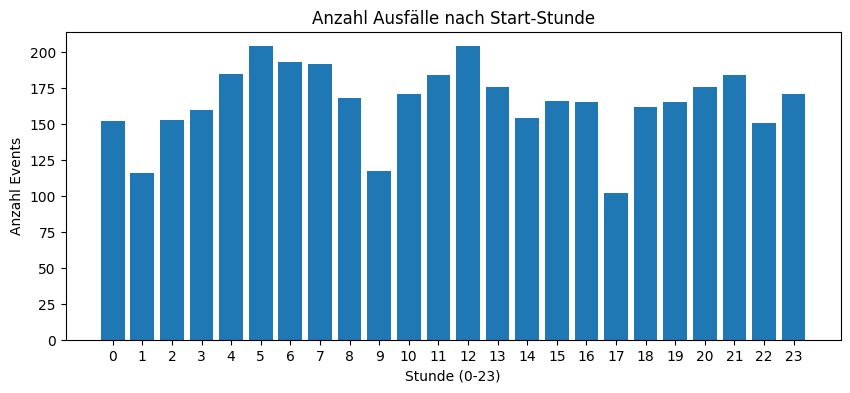

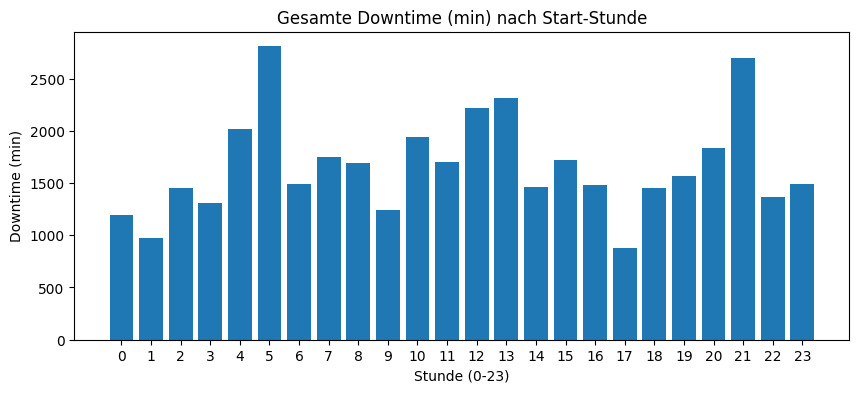

In [10]:
df_out["Start_hour"] = df_out["Start"].dt.hour
hour_stats = (df_out.dropna(subset=["Start_hour"])
              .groupby("Start_hour")
              .agg(events=("Downtime_min","size"),
                   downtime_min=("Downtime_min","sum"),
                   avg_downtime=("Downtime_min","mean"))
              .reset_index()
              .sort_values("Start_hour"))

display(hour_stats)

plt.figure(figsize=(10,4))
plt.bar(hour_stats["Start_hour"], hour_stats["events"])
plt.title("Anzahl Ausfälle nach Start-Stunde")
plt.xlabel("Stunde (0-23)")
plt.ylabel("Anzahl Events")
plt.xticks(range(0,24,1))
plt.show()

plt.figure(figsize=(10,4))
plt.bar(hour_stats["Start_hour"], hour_stats["downtime_min"])
plt.title("Gesamte Downtime (min) nach Start-Stunde")
plt.xlabel("Stunde (0-23)")
plt.ylabel("Downtime (min)")
plt.xticks(range(0,24,1))
plt.show()


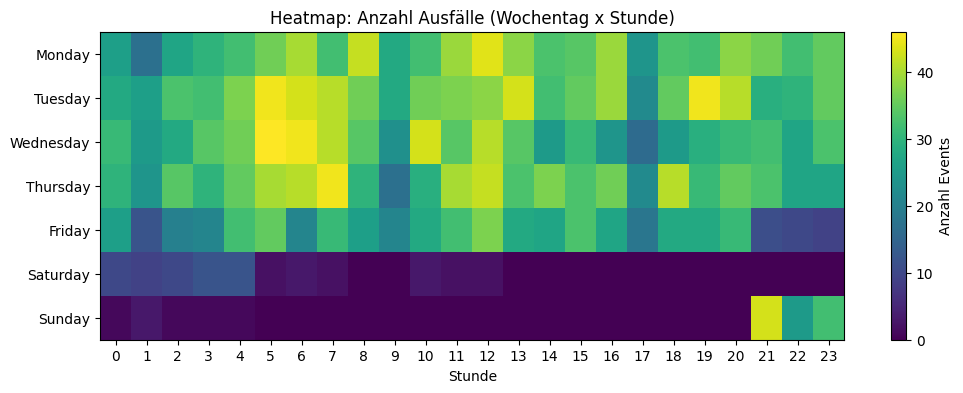

Start_hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
DayName,,,,,,,,,,,,,,,,,,,,,,,,
Monday,26,17,27,30,32,36,40,32,42,28,32,39,44,38,33,34,39,24,33,32,38,36,32,35
Tuesday,28,26,33,32,37,45,43,41,36,28,36,37,38,43,32,35,39,22,35,45,41,29,30,35
Wednesday,31,25,28,34,36,46,45,41,34,23,43,34,41,34,25,31,24,16,25,29,31,32,27,33
Thursday,30,24,34,30,35,40,41,45,30,17,29,40,42,33,37,33,36,22,41,31,35,33,27,27
Friday,26,12,20,21,32,35,21,31,26,21,28,32,37,28,27,33,27,18,28,28,31,11,10,9
Saturday,10,9,10,12,12,2,3,2,0,0,3,2,2,0,0,0,0,0,0,0,0,0,0,0
Sunday,1,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,25,32


In [11]:
# Heatmap: Wochentag x Stunde (Event-Anzahl)
df_out["DayName"] = df_out["Datum"].dt.day_name()
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

heat = (df_out.pivot_table(index="DayName", columns="Start_hour", values="Downtime_min",
                           aggfunc="size", fill_value=0)
        .reindex(order))

plt.figure(figsize=(12,4))
plt.imshow(heat.values, aspect="auto")
plt.title("Heatmap: Anzahl Ausfälle (Wochentag x Stunde)")
plt.yticks(range(len(heat.index)), heat.index)
plt.xticks(range(0,24,1), range(0,24,1))
plt.xlabel("Stunde")
plt.colorbar(label="Anzahl Events")
plt.show()

display(heat)


## 3) Welche Maschinen/Stationen haben die meisten Fehler?

,events,downtime_min,avg_downtime
Station_norm,,,
R 06,559,3519.0,6.29517
R 09,445,2756.0,6.193258
R 07,334,2136.0,6.39521
R 02,321,2733.0,8.514019
OP 100 R,312,2953.0,9.464744
R 03,264,1626.0,6.159091
R 08,181,1456.0,8.044199
OP 100 L,139,1891.0,13.604317
R 04,125,925.0,7.4


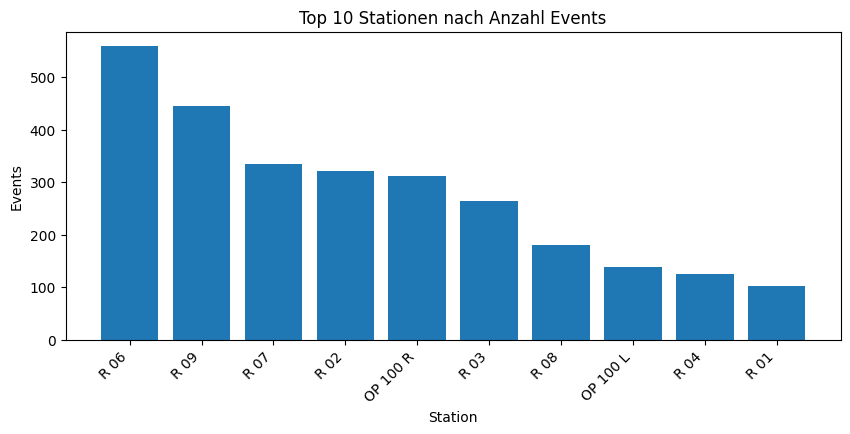

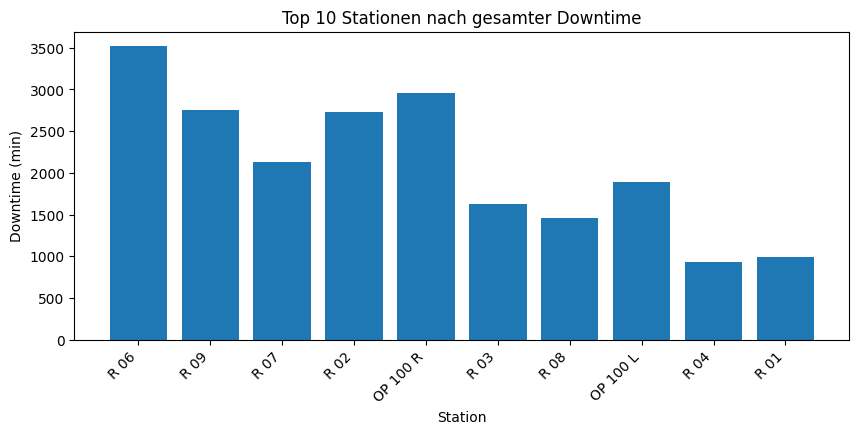

In [12]:
df_out["Station_norm"] = (df_out["Station/ OP"].astype("string")
                          .str.upper()
                          .str.replace(r"\s+", " ", regex=True)
                          .str.strip())

station_stats = (df_out.groupby("Station_norm")
                 .agg(events=("Downtime_min","size"),
                      downtime_min=("Downtime_min","sum"),
                      avg_downtime=("Downtime_min","mean"))
                 .sort_values(["events","downtime_min"], ascending=False))

display(station_stats.head(20))

top10 = station_stats.head(10).reset_index()

plt.figure(figsize=(10,4))
plt.bar(top10["Station_norm"], top10["events"])
plt.title("Top 10 Stationen nach Anzahl Events")
plt.xlabel("Station")
plt.ylabel("Events")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(top10["Station_norm"], top10["downtime_min"])
plt.title("Top 10 Stationen nach gesamter Downtime")
plt.xlabel("Station")
plt.ylabel("Downtime (min)")
plt.xticks(rotation=45, ha="right")
plt.show()


## 4) Welche Fehler/Ursachen wie oft? (Unterbrechungsursache)

,events,total_downtime,avg_downtime,median_downtime
Unterbrechungsursache,,,,
Freitext,1238,14736.0,11.903069,8.0
Zündfehler,910,4524.0,4.971429,5.0
Bauteil nicht gespannt,254,1446.0,5.692913,5.0
Gasdüse und Kontaktrohr getauscht,248,1889.0,7.616935,8.0
Wartungsplan,246,5312.0,21.593496,23.0
Reinigung,235,4151.0,17.66383,15.0
Gasdüse getauscht,102,513.0,5.029412,5.0
Sensor Schaltet nicht,92,597.0,6.48913,5.0
Bauteil fallen gelassen,81,870.0,10.740741,10.0


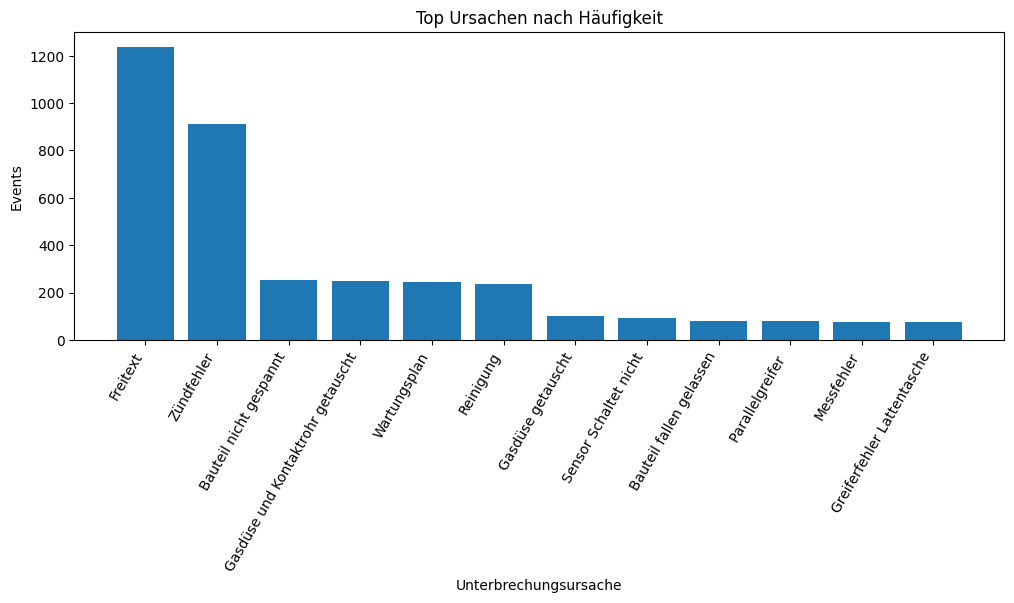

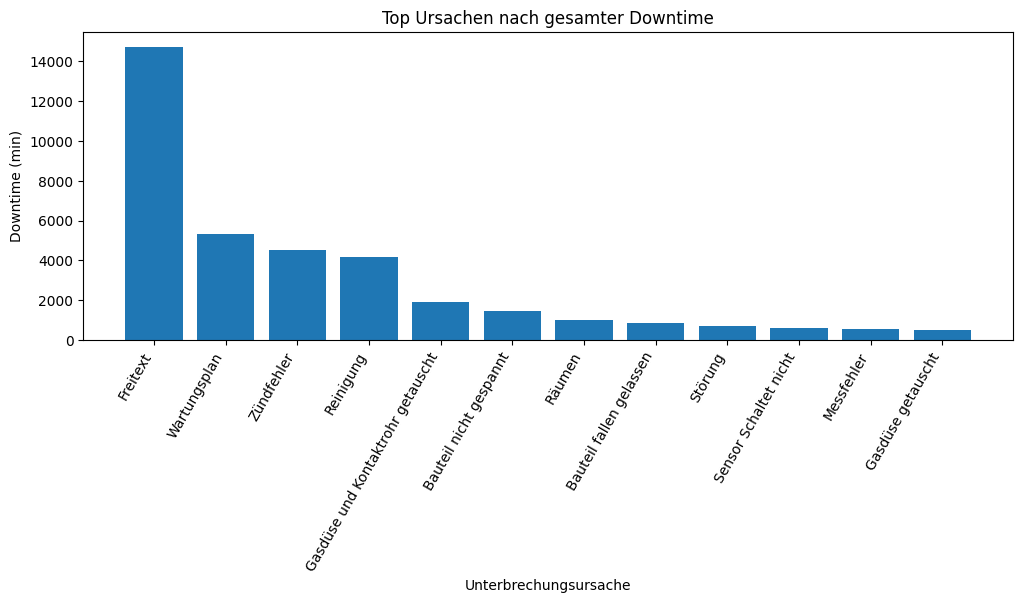

In [13]:
cause_stats = (df_out.groupby("Unterbrechungsursache")
               .agg(events=("Downtime_min","size"),
                    total_downtime=("Downtime_min","sum"),
                    avg_downtime=("Downtime_min","mean"),
                    median_downtime=("Downtime_min","median"))
               .sort_values("events", ascending=False))

display(cause_stats.head(20))

top_causes = cause_stats.head(12).reset_index()

plt.figure(figsize=(12,4))
plt.bar(top_causes["Unterbrechungsursache"].astype(str), top_causes["events"])
plt.title("Top Ursachen nach Häufigkeit")
plt.xlabel("Unterbrechungsursache")
plt.ylabel("Events")
plt.xticks(rotation=60, ha="right")
plt.show()

top_causes_downtime = cause_stats.sort_values("total_downtime", ascending=False).head(12).reset_index()

plt.figure(figsize=(12,4))
plt.bar(top_causes_downtime["Unterbrechungsursache"].astype(str), top_causes_downtime["total_downtime"])
plt.title("Top Ursachen nach gesamter Downtime")
plt.xlabel("Unterbrechungsursache")
plt.ylabel("Downtime (min)")
plt.xticks(rotation=60, ha="right")
plt.show()


## 5) Auffälligkeiten bei der Ausfalldauer (Kombinationen, Ausreißer)

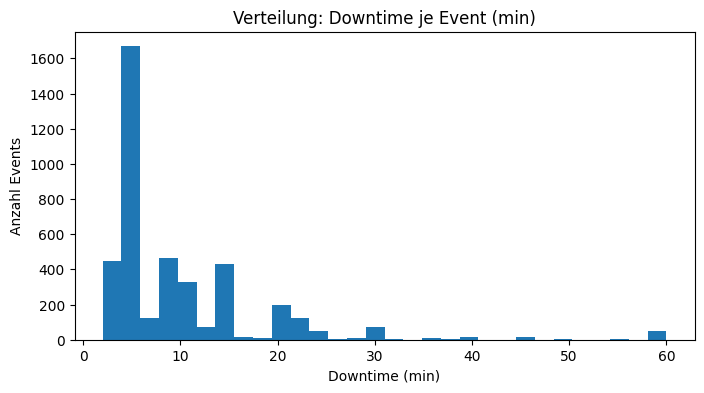

C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\2953836716.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


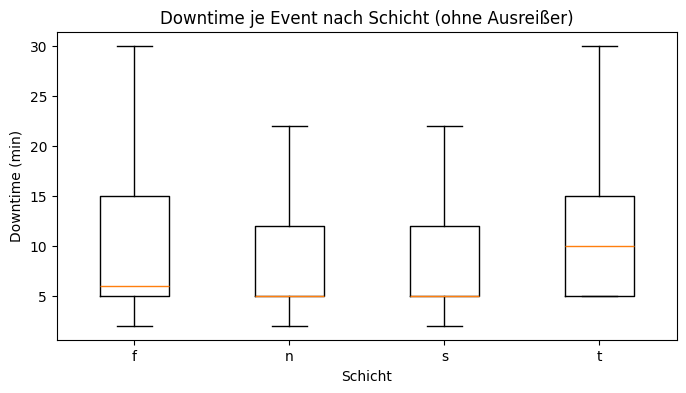

,Datum,Start,End,Schicht,Station_norm,Unterbrechungsursache,Downtime_min,Bemerkung
5,2023-01-05,2023-01-05 08:00:00,2023-01-05 09:00:00,t,R 03,Freitext,60.0,"Programmfehler, Greifer defekt, räumen"
821,2023-01-17,2023-01-17 11:00:00,2023-01-17 12:00:00,f,<NA>,Freitext,60.0,RobTech demontiert zwecks Abluftanlagentranspo...
2189,2023-02-03,2023-02-03 03:00:00,2023-02-03 04:00:00,n,OP 100 L,Freitext,60.0,"Hydraulikleckage, Schlosser informiert"
8701,2023-05-11,2023-05-11 11:00:00,2023-05-11 12:00:00,f,<NA>,Reinigung,60.0,Wartung/Reinigung!!! Rob Tech in der Anlage
6857,2023-04-05,2023-04-05 15:00:00,2023-04-05 16:00:00,s,<NA>,NaN,60.0,"Wöchentliche/Monatliche Wartung, Reinigung."
6869,2023-04-05,2023-04-05 18:00:00,2023-04-05 19:00:00,s,<NA>,NaN,60.0,"Wöchentliche/Monatliche Wartung, Reinigung."
6033,2023-03-27,2023-03-27 00:00:00,2023-03-27 01:00:00,n,"OP 10, OP 20, OP 40 R",Freitext,60.0,R 01 legt Bauteil falsch ab und lässt Bauteile...
2741,2023-02-10,2023-02-10 05:00:00,2023-02-10 06:00:00,f,<NA>,MES Probleme,60.0,"Auftragspuffer leer, Reinigung."
185,2023-01-09,2023-01-09 21:00:00,2023-01-09 22:00:00,n,<NA>,Warten auf Material,60.0,"2.4 falsche Deckbleche gepackt, Kommissioniere..."
6877,2023-04-05,2023-04-05 20:00:00,2023-04-05 21:00:00,s,<NA>,NaN,60.0,"Wöchentliche/Monatliche Wartung, Reinigung."


In [14]:
# Verteilung der Downtime
plt.figure(figsize=(8,4))
plt.hist(df_out["Downtime_min"].dropna(), bins=30)
plt.title("Verteilung: Downtime je Event (min)")
plt.xlabel("Downtime (min)")
plt.ylabel("Anzahl Events")
plt.show()

# Downtime nach Schicht (Boxplot)
plt.figure(figsize=(8,4))
data = [df_out.loc[df_out["Schicht"]==s, "Downtime_min"].dropna() for s in sorted(df_out["Schicht"].dropna().unique())]
labels = [s for s in sorted(df_out["Schicht"].dropna().unique())]
plt.boxplot(data, labels=labels, showfliers=False)
plt.title("Downtime je Event nach Schicht (ohne Ausreißer)")
plt.xlabel("Schicht")
plt.ylabel("Downtime (min)")
plt.show()

# Ausreißer: Top 20 längste Events
top_long = (df_out.sort_values("Downtime_min", ascending=False)
            .loc[:, ["Datum","Start","End","Schicht","Station_norm","Unterbrechungsursache","Downtime_min","Bemerkung"]]
            .head(20))
display(top_long)


,Downtime_min,Dauer Arbeits-zeit,Anzahl MA,Menge N.i. O.,Profi,AHV,Menge Gesamt (Stück)
Downtime_min,1.000000,-0.034772,-0.006763,0.107296,-0.171686,-0.062371,-0.244859
Dauer Arbeits-zeit,-0.034772,1.000000,-0.012677,0.008303,0.121397,0.074485,0.155107
Anzahl MA,-0.006763,-0.012677,1.000000,-0.021600,0.046789,0.021322,0.040388
Menge N.i. O.,0.107296,0.008303,-0.021600,1.000000,-0.234689,-0.019011,-0.009709
Profi,-0.171686,0.121397,0.046789,-0.234689,1.000000,-0.485127,0.718987
AHV,-0.062371,0.074485,0.021322,-0.019011,-0.485127,1.000000,0.462053
Menge Gesamt (Stück),-0.244859,0.155107,0.040388,-0.009709,0.718987,0.462053,1.000000


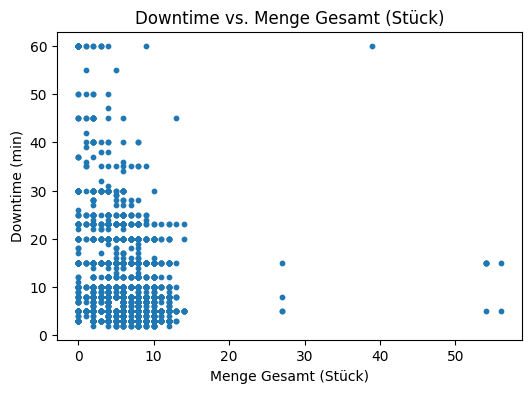

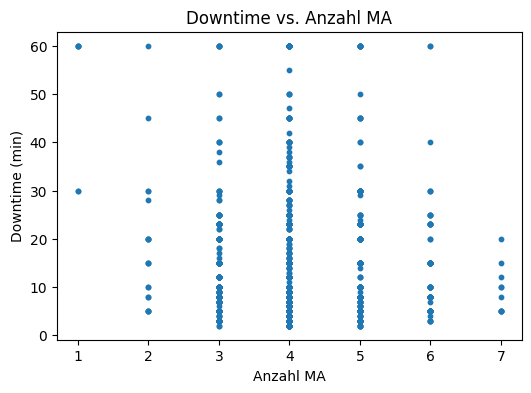

,events,avg_downtime,total_downtime
Anzahl MA,,,
1.0,6,50.0,300.0
2.0,20,18.7,374.0
3.0,611,10.271686,6276.0
4.0,2631,9.689092,25492.0
5.0,702,9.908832,6956.0
6.0,97,11.319588,1098.0
7.0,11,9.090909,100.0


In [15]:
# Zusammenhang mit Output / Personal (wenn vorhanden)
num_cols = ["Downtime_min", "Dauer Arbeits-zeit", "Anzahl MA", "Menge N.i. O.", "Profi", "AHV", "Menge Gesamt (Stück)"]
corr = df_out[num_cols].corr(method="spearman", numeric_only=True)
display(corr)

# Scatter: Downtime vs Menge Gesamt
plt.figure(figsize=(6,4))
x = df_out["Menge Gesamt (Stück)"]
y = df_out["Downtime_min"]
plt.scatter(x, y, s=10)
plt.title("Downtime vs. Menge Gesamt (Stück)")
plt.xlabel("Menge Gesamt (Stück)")
plt.ylabel("Downtime (min)")
plt.show()

# Scatter: Downtime vs Anzahl MA
plt.figure(figsize=(6,4))
x = df_out["Anzahl MA"]
y = df_out["Downtime_min"]
plt.scatter(x, y, s=10)
plt.title("Downtime vs. Anzahl MA")
plt.xlabel("Anzahl MA")
plt.ylabel("Downtime (min)")
plt.show()

# Aggregation nach Anzahl MA
ma_stats = (df_out.groupby("Anzahl MA")
            .agg(events=("Downtime_min","size"),
                 avg_downtime=("Downtime_min","mean"),
                 total_downtime=("Downtime_min","sum"))
            .sort_index())
display(ma_stats)


## 6) Ideen für nächste Schritte

- **Freitext reduzieren:** „Freitext“ ist sehr häufig – ideal wäre eine standardisierte Fehlerklassifikation (Dropdown).
- **Stationen konsolidieren:** z.B. `R 06` vs. `R06` (falls vorhanden) vereinheitlichen.
- **Ausfälle nach Priorität:** Fokus auf Kombination aus **hoher Downtime** + **hoher Häufigkeit** (Pareto).
- **Geplante vs. ungeplante Stops:** Ursachen wie „Wartungsplan“/„Reinigung“ ggf. separat betrachten.


## 7) Zusammenhänge: Schicht × Zeit × MA × Downtime × Ursache

Die folgenden Blöcke zeigen dir die wichtigsten Kombinationen aus **Schicht**, **Uhrzeit**, **Anzahl MA**, **Ausfalldauer** und **Ursache** – als Tabellen und Visualisierungen.

> Tipp: Wenn du sehr viele Ursachen hast, nutze die *Top-N*-Filter in den Zellen, damit die Plots lesbar bleiben.


In [16]:
# --- Feature Engineering für Zusammenhangsanalysen ---
df = df_clean.copy()

# Robustheit / Standardisierung
df["Ursache"] = df.get("Unterbrechungsursache", pd.Series(index=df.index)).fillna("Unbekannt").astype(str).str.strip()
df["Station"] = df.get("Station/ OP", pd.Series(index=df.index)).fillna("Unbekannt").astype(str).str.strip()

# Schicht-Label (Codes aus deinen Daten: f/s/n/t)
shift_map = {"f": "Früh", "s": "Spät", "n": "Nacht", "t": "Tag"}
df["Schicht_label"] = df.get("Schicht", pd.Series(index=df.index)).map(shift_map)
df["Schicht_label"] = df["Schicht_label"].fillna(df.get("Schicht", pd.Series(index=df.index)).fillna("Unbekannt").astype(str))

# Zeit-Features
df["Start_ts"] = pd.to_datetime(df.get("Start", pd.Series(index=df.index)), errors="coerce")
df["Start_date"] = df["Start_ts"].dt.date
df["Start_hour"] = df["Start_ts"].dt.hour

weekday_de = {0:"Mo", 1:"Di", 2:"Mi", 3:"Do", 4:"Fr", 5:"Sa", 6:"So"}
df["Wochentag_de"] = df["Start_ts"].dt.dayofweek.map(weekday_de)

# Anzahl MA (numerisch) + Bins
df["MA"] = pd.to_numeric(df.get("Anzahl MA", pd.Series(index=df.index)), errors="coerce")
df["MA_bin"] = pd.cut(
    df["MA"],
    bins=[-0.1, 2, 3, 4, 5, 6, 99],
    labels=["<=2", "3", "4", "5", "6", ">=7"]
)

# Downtime (numerisch) + Bins
df["Downtime_min"] = pd.to_numeric(df.get("Downtime_min", pd.Series(index=df.index)), errors="coerce")
df["Downtime_bin"] = pd.cut(
    df["Downtime_min"],
    bins=[-0.1, 0, 5, 15, 30, 60, 999999],
    labels=["0", "1-5", "6-15", "16-30", "31-60", ">60"]
)

# Time-Blocks (optional)
df["Tagesblock"] = pd.cut(
    df["Start_hour"],
    bins=[-0.1, 5, 11, 17, 23],
    labels=["Nacht(0-5)", "Vormittag(6-11)", "Nachmittag(12-17)", "Abend(18-23)"]
)

# Quick-Checks
print("Zeilen:", len(df))
print("Schichten:", df["Schicht_label"].value_counts(dropna=False).to_dict())
print("Top Ursachen:", df["Ursache"].value_counts().head(10).to_dict())


Zeilen: 4781
Schichten: {'Früh': 1633, 'Nacht': 1507, 'Spät': 1465, 'Unbekannt': 148, 'Tag': 28}
Top Ursachen: {'Freitext': 1282, 'Zündfehler': 921, 'Bauteil nicht gespannt': 713, 'Gasdüse und Kontaktrohr getauscht': 248, 'Wartungsplan': 247, 'Reinigung': 240, 'Greiferfehler Lattentasche': 117, 'Gasdüse getauscht': 103, 'Bauteil fallen gelassen': 95, 'Sensor Schaltet nicht': 94}


In [17]:
# --- Hilfsfunktionen (Heatmap + Top-Kombinationen) ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_heatmap(pivot: pd.DataFrame, title: str, xlabel: str = "", ylabel: str = "", annotate: bool = False):
    # pivot: index=y, columns=x, values=z (numeric)
    if pivot.empty:
        print("Pivot ist leer – nichts zu plotten.")
        return

    data = pivot.values.astype(float)
    fig, ax = plt.subplots(figsize=(max(8, 0.45*len(pivot.columns)), max(3, 0.45*len(pivot.index))))
    im = ax.imshow(data, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.set_xticks(np.arange(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=90)
    ax.set_yticks(np.arange(len(pivot.index)))
    ax.set_yticklabels(pivot.index)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if annotate and data.size <= 600:  # nur kleine Heatmaps annotieren
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                v = data[i, j]
                if np.isfinite(v):
                    ax.text(j, i, f"{v:.0f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

def top_combos(df_in: pd.DataFrame, group_cols, n=20, sort_by="downtime_sum"):
    g = (df_in
         .groupby(group_cols, dropna=False)
         .agg(events=("Downtime_min", "size"),
              downtime_sum=("Downtime_min", "sum"),
              downtime_avg=("Downtime_min", "mean"),
              downtime_median=("Downtime_min", "median"))
         .reset_index()
        )
    return g.sort_values(sort_by, ascending=False).head(n)


### 7.1 Schicht × Uhrzeit (Stoßzeiten je Schicht)

- **Heatmap Events** zeigt, wann in welcher Schicht die meisten Ereignisse starten.
- **Heatmap Downtime-Summe** zeigt, wann die teuersten Zeitfenster sind.


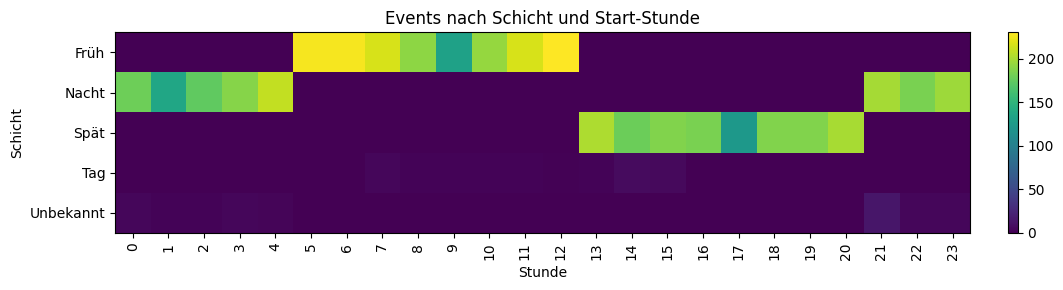

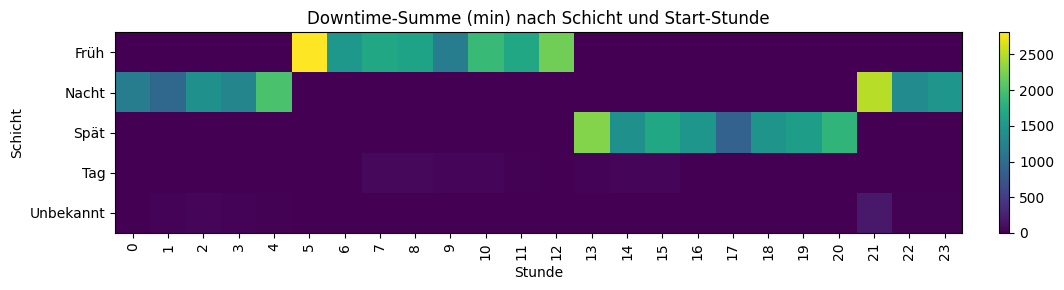

Start_hour,0,3,4,5,6,7,9,11,12,13,14,15,18,19,20,21,22,23
Schicht_label,,,,,,,,,,,,,,,,,,
Früh,NaN,NaN,NaN,227.0,227.0,216.0,NaN,216.0,230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nacht,NaN,188.0,209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,199.0,184.0,196.0
Spät,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.0,NaN,186.0,186.0,186.0,200.0,NaN,NaN,NaN
Tag,NaN,NaN,NaN,NaN,NaN,4.0,2.0,NaN,NaN,2.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
Unbekannt,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,4.0,4.0


In [18]:
# --- Schicht × Stunde: Events & Downtime ---
pivot_events = pd.pivot_table(
    df, index="Schicht_label", columns="Start_hour",
    values="Downtime_min", aggfunc="size", fill_value=0
).reindex(columns=list(range(24)), fill_value=0)

pivot_downtime = pd.pivot_table(
    df, index="Schicht_label", columns="Start_hour",
    values="Downtime_min", aggfunc="sum", fill_value=0
).reindex(columns=list(range(24)), fill_value=0)

plot_heatmap(pivot_events, "Events nach Schicht und Start-Stunde", xlabel="Stunde", ylabel="Schicht", annotate=False)
plot_heatmap(pivot_downtime, "Downtime-Summe (min) nach Schicht und Start-Stunde", xlabel="Stunde", ylabel="Schicht", annotate=False)

# Top-Stunden je Schicht (nach Events)
pivot_events.apply(lambda s: s.sort_values(ascending=False).head(5), axis=1)


### 7.2 Ursache × Schicht (welche Ursachen dominieren in welcher Schicht?)

- **Top-N Ursachen** filtern, damit die Darstellung übersichtlich bleibt.
- Tabellen zeigen **Events**, **Downtime-Summe** und **Ø-Downtime**.


,Schicht_label,Ursache,events,downtime_sum,downtime_avg
2,Früh,Freitext,418,4664.0,11.157895
11,Früh,Zündfehler,295,1409.0,4.776271
1,Früh,Bauteil nicht gespannt,229,480.0,2.09607
4,Früh,Gasdüse und Kontaktrohr getauscht,107,800.0,7.476636
7,Früh,Reinigung,90,1921.0,21.344444
10,Früh,Wartungsplan,84,1858.0,22.119048
5,Früh,Greiferfehler Lattentasche,57,180.0,3.157895
0,Früh,Bauteil fallen gelassen,42,338.0,8.047619
8,Früh,Sensor Schaltet nicht,38,221.0,5.815789
3,Früh,Gasdüse getauscht,30,157.0,5.233333


C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\1337832046.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


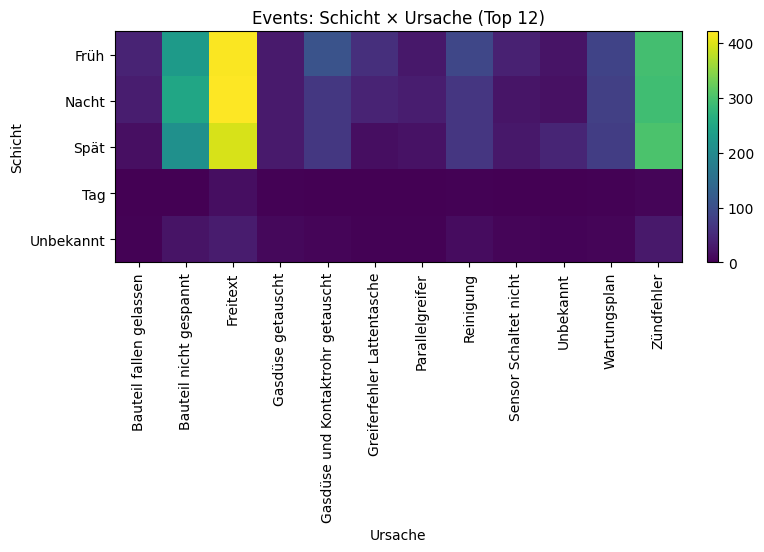

C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\1337832046.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


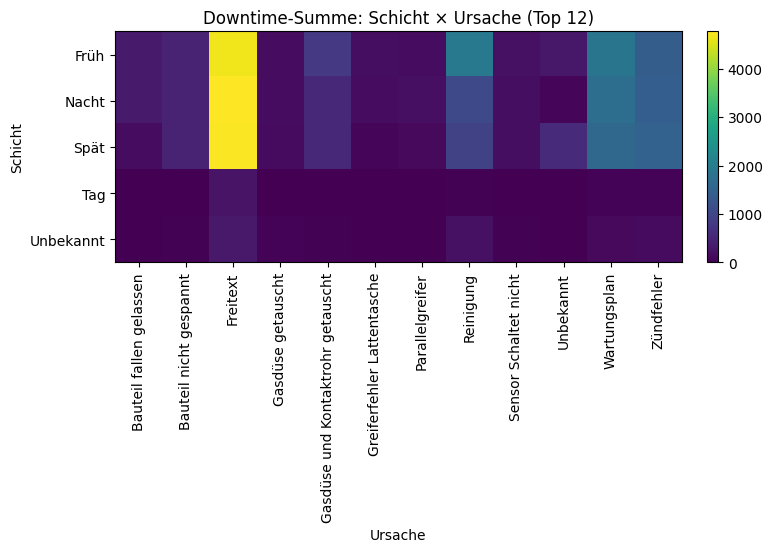

C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\1337832046.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


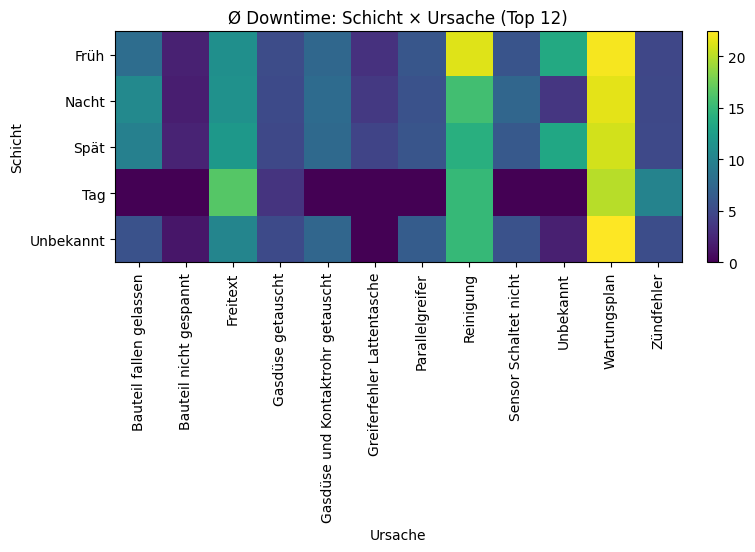

In [19]:
# --- Ursache × Schicht (Top-N) ---
TOP_N = 12  # anpassen
top_causes = df["Ursache"].value_counts().head(TOP_N).index
df_top = df[df["Ursache"].isin(top_causes)].copy()

tbl_shift_cause = (df_top
    .groupby(["Schicht_label", "Ursache"], dropna=False)
    .agg(events=("Downtime_min","size"),
         downtime_sum=("Downtime_min","sum"),
         downtime_avg=("Downtime_min","mean"))
    .reset_index()
    .sort_values(["Schicht_label","events"], ascending=[True,False])
)
display(tbl_shift_cause)

pivot_sc_events = tbl_shift_cause.pivot(index="Schicht_label", columns="Ursache", values="events").fillna(0)
pivot_sc_sum   = tbl_shift_cause.pivot(index="Schicht_label", columns="Ursache", values="downtime_sum").fillna(0)
pivot_sc_avg   = tbl_shift_cause.pivot(index="Schicht_label", columns="Ursache", values="downtime_avg").fillna(0)

plot_heatmap(pivot_sc_events, f"Events: Schicht × Ursache (Top {TOP_N})", xlabel="Ursache", ylabel="Schicht", annotate=False)
plot_heatmap(pivot_sc_sum,   f"Downtime-Summe: Schicht × Ursache (Top {TOP_N})", xlabel="Ursache", ylabel="Schicht", annotate=False)
plot_heatmap(pivot_sc_avg,   f"Ø Downtime: Schicht × Ursache (Top {TOP_N})", xlabel="Ursache", ylabel="Schicht", annotate=False)


### 7.3 Ursache × Uhrzeit (wann tritt welche Ursache auf?)

Hier siehst du, ob bestimmte Ursachen **zu bestimmten Uhrzeiten** gehäuft auftreten.


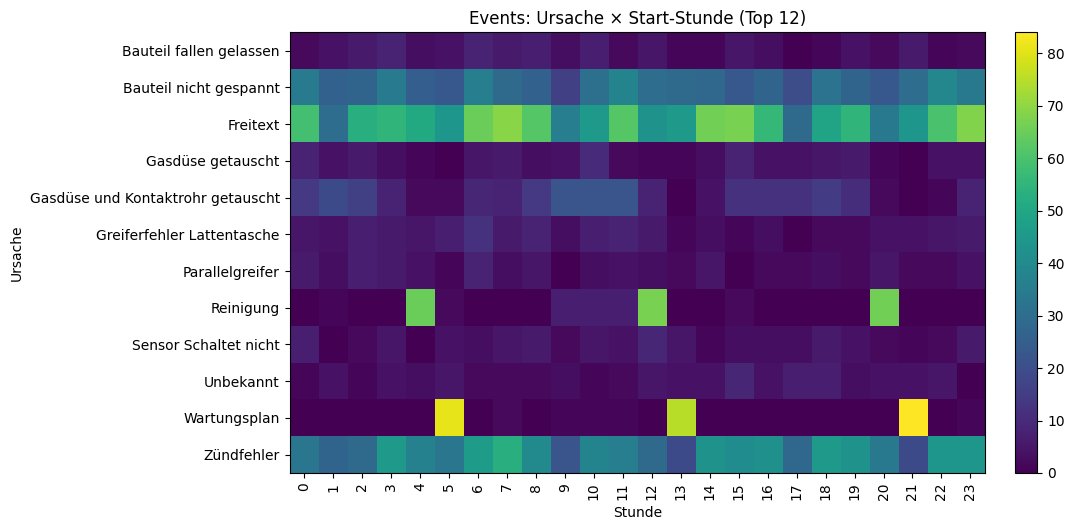

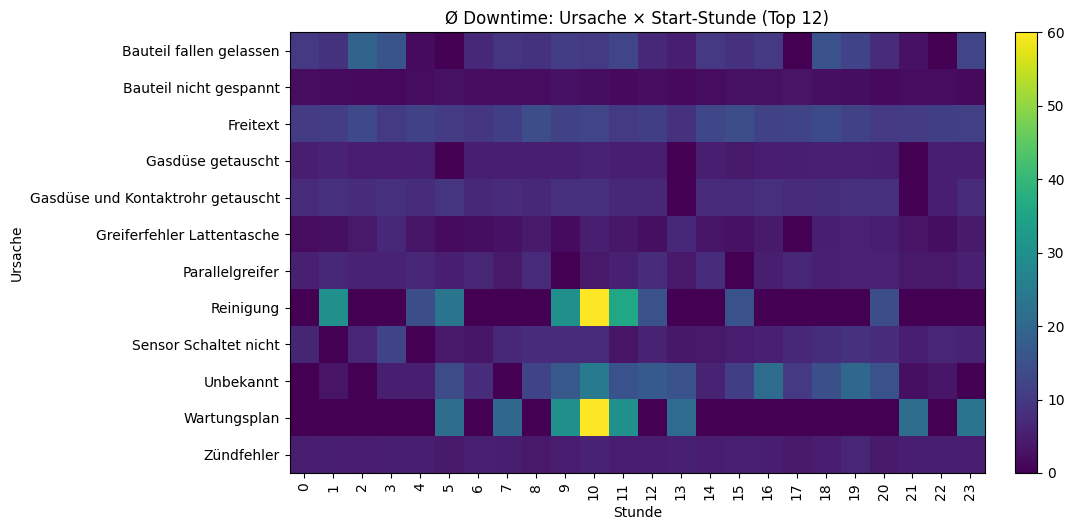

In [20]:
# --- Ursache × Stunde (Top-N nach Häufigkeit) ---
TOP_N = 12  # anpassen
top_causes = df["Ursache"].value_counts().head(TOP_N).index
df_top = df[df["Ursache"].isin(top_causes)].copy()

pivot_cause_hour_cnt = pd.pivot_table(
    df_top, index="Ursache", columns="Start_hour",
    values="Downtime_min", aggfunc="size", fill_value=0
).reindex(columns=list(range(24)), fill_value=0)

pivot_cause_hour_avg = pd.pivot_table(
    df_top, index="Ursache", columns="Start_hour",
    values="Downtime_min", aggfunc="mean", fill_value=0
).reindex(columns=list(range(24)), fill_value=np.nan)

plot_heatmap(pivot_cause_hour_cnt, f"Events: Ursache × Start-Stunde (Top {TOP_N})", xlabel="Stunde", ylabel="Ursache", annotate=False)
plot_heatmap(pivot_cause_hour_avg, f"Ø Downtime: Ursache × Start-Stunde (Top {TOP_N})", xlabel="Stunde", ylabel="Ursache", annotate=False)


### 7.4 Anzahl MA × Downtime (und Interaktion mit Schicht/Ursache)

Diese Blöcke zeigen:
- ob mehr/weniger Personal mit **längerer/kürzerer Downtime** zusammenhängt,
- ob der Zusammenhang **je Schicht** oder **je Ursache** unterschiedlich ist.


Korrelation MA ↔ Downtime (Spearman): -0.024
Korrelation MA ↔ Downtime (Pearson):  -0.047


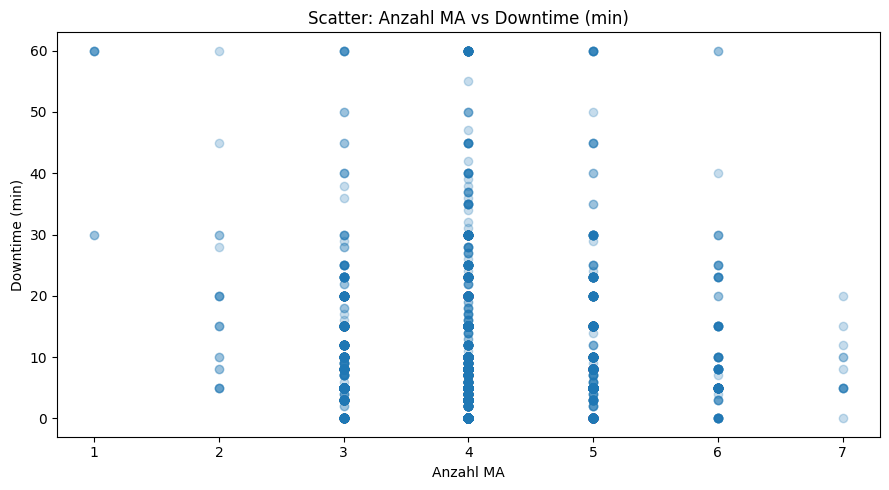

,Schicht_label,MA,events,downtime_sum,downtime_avg
0,Früh,2.0,7,129.0,18.428571
1,Früh,3.0,221,2179.0,9.859729
2,Früh,4.0,1169,9983.0,8.539778
3,Früh,5.0,195,1829.0,9.379487
4,Früh,6.0,21,244.0,11.619048
5,Nacht,1.0,3,150.0,50.0
6,Nacht,3.0,201,1982.0,9.860697
7,Nacht,4.0,908,7364.0,8.110132
8,Nacht,5.0,367,2696.0,7.346049
9,Nacht,6.0,16,201.0,12.5625


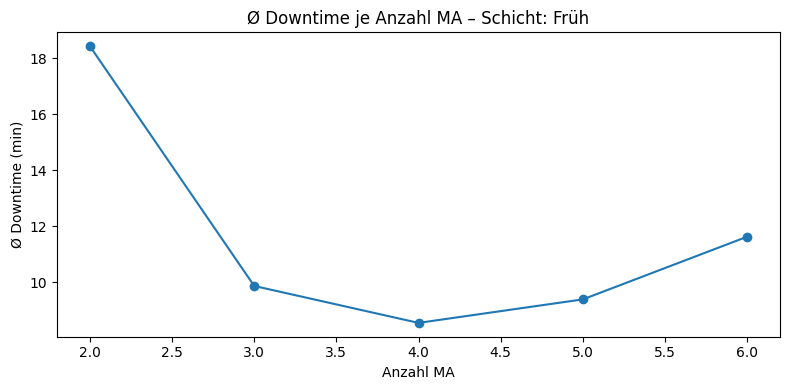

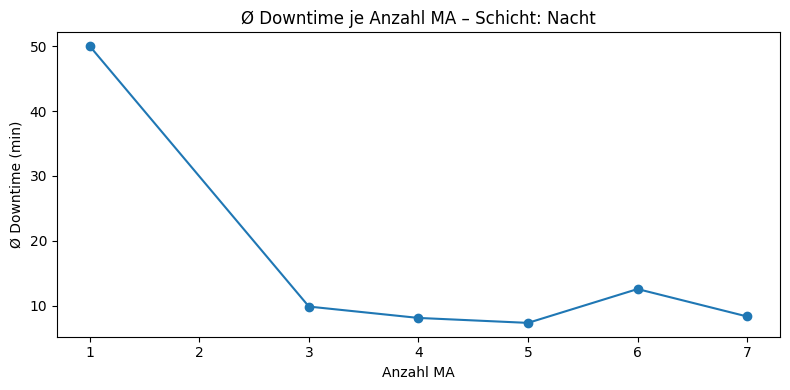

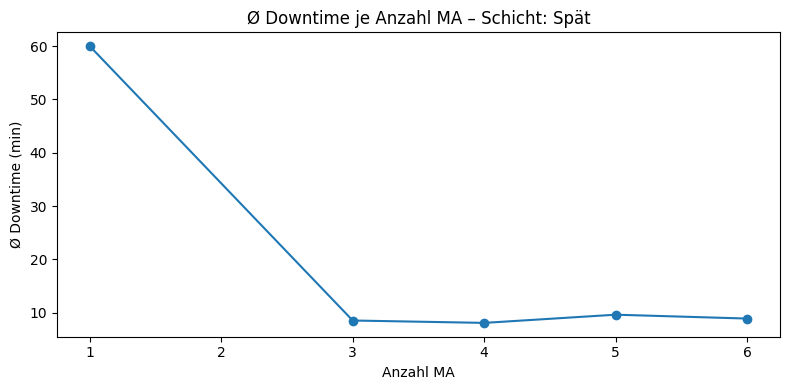

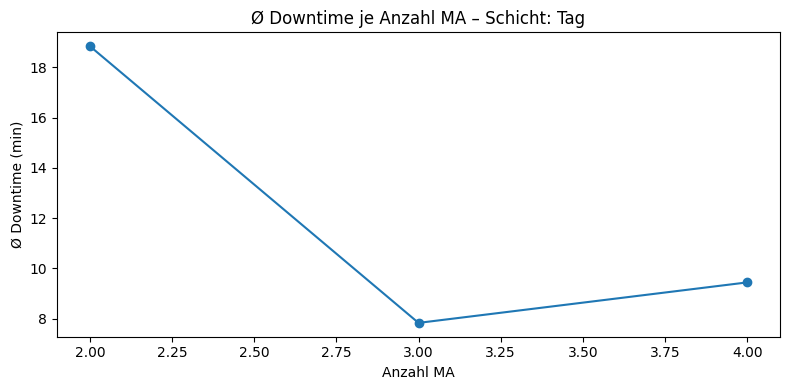

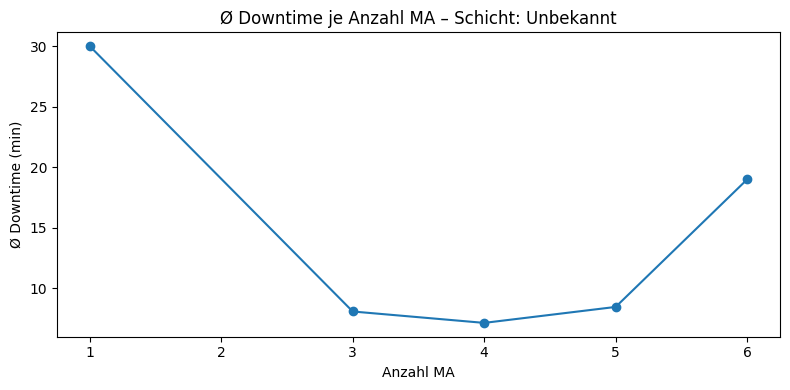

In [21]:
# --- MA × Downtime: Überblick ---
tmp = df.dropna(subset=["MA", "Downtime_min"]).copy()

# Korrelationen (robust: Spearman)
spearman = tmp[["MA","Downtime_min"]].corr(method="spearman").iloc[0,1]
pearson  = tmp[["MA","Downtime_min"]].corr(method="pearson").iloc[0,1]
print("Korrelation MA ↔ Downtime (Spearman):", round(float(spearman), 3))
print("Korrelation MA ↔ Downtime (Pearson): ", round(float(pearson), 3))

# Scatter (MA vs Downtime)
plt.figure(figsize=(9,5))
plt.scatter(tmp["MA"], tmp["Downtime_min"], alpha=0.25)
plt.title("Scatter: Anzahl MA vs Downtime (min)")
plt.xlabel("Anzahl MA")
plt.ylabel("Downtime (min)")
plt.tight_layout()
plt.show()

# Gruppiert: Schicht × MA (Events / Ø / Summe)
tbl_shift_ma = (tmp
    .groupby(["Schicht_label","MA"], dropna=False)
    .agg(events=("Downtime_min","size"),
         downtime_sum=("Downtime_min","sum"),
         downtime_avg=("Downtime_min","mean"))
    .reset_index()
    .sort_values(["Schicht_label","MA"])
)
display(tbl_shift_ma)

# Plot: Ø Downtime je MA und Schicht
for sh in sorted(tbl_shift_ma["Schicht_label"].dropna().unique()):
    sub = tbl_shift_ma[tbl_shift_ma["Schicht_label"]==sh]
    plt.figure(figsize=(8,4))
    plt.plot(sub["MA"], sub["downtime_avg"], marker="o")
    plt.title(f"Ø Downtime je Anzahl MA – Schicht: {sh}")
    plt.xlabel("Anzahl MA")
    plt.ylabel("Ø Downtime (min)")
    plt.tight_layout()
    plt.show()


,Ursache,MA,events,downtime_sum,downtime_avg
0,Bauteil fallen gelassen,3.0,17,254.0,14.941176
1,Bauteil fallen gelassen,4.0,63,485.0,7.698413
2,Bauteil fallen gelassen,5.0,12,119.0,9.916667
3,Bauteil fallen gelassen,6.0,3,12.0,4.0
4,Bauteil nicht gespannt,3.0,57,100.0,1.754386
5,Bauteil nicht gespannt,4.0,516,1127.0,2.184109
6,Bauteil nicht gespannt,5.0,121,171.0,1.413223
7,Bauteil nicht gespannt,6.0,12,33.0,2.75
8,Bauteil nicht gespannt,7.0,1,0.0,0.0
9,Freitext,1.0,5,270.0,54.0


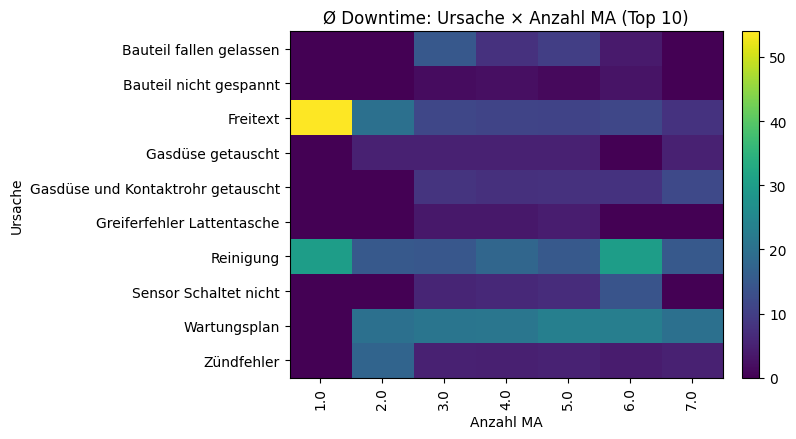

In [22]:
# --- MA × Downtime × Ursache (Top-N Ursachen) ---
TOP_N = 10
top_causes = df["Ursache"].value_counts().head(TOP_N).index
tmp = df[df["Ursache"].isin(top_causes)].dropna(subset=["MA","Downtime_min"]).copy()

tbl_cause_ma = (tmp
    .groupby(["Ursache","MA"], dropna=False)
    .agg(events=("Downtime_min","size"),
         downtime_sum=("Downtime_min","sum"),
         downtime_avg=("Downtime_min","mean"))
    .reset_index()
    .sort_values(["Ursache","MA"])
)
display(tbl_cause_ma)

pivot = tbl_cause_ma.pivot(index="Ursache", columns="MA", values="downtime_avg").fillna(0)
plot_heatmap(pivot, f"Ø Downtime: Ursache × Anzahl MA (Top {TOP_N})", xlabel="Anzahl MA", ylabel="Ursache", annotate=False)


### 7.5 Dreifach-Kombinationen (Schicht × Station × Ursache)

Damit findest du die **teuersten** und **häufigsten** Problemkombinationen.


In [23]:
# --- Top Kombinationen nach Downtime-Summe ---
top_by_sum = top_combos(df, ["Schicht_label", "Station", "Ursache"], n=25, sort_by="downtime_sum")
display(top_by_sum)

# --- Top Kombinationen nach Häufigkeit (Events) ---
top_by_events = top_combos(df, ["Schicht_label", "Station", "Ursache"], n=25, sort_by="events")
display(top_by_events)

# Optional: nur ungeplante Ursachen (simple Heuristik – anpassen!)
planned_patterns = r"(wartung|reinigung|geplant|plan|service)"
df_unplanned = df[~df["Ursache"].str.contains(planned_patterns, case=False, na=False)].copy()

top_unplanned_sum = top_combos(df_unplanned, ["Schicht_label","Station","Ursache"], n=25, sort_by="downtime_sum")
display(top_unplanned_sum)


,Schicht_label,Station,Ursache,events,downtime_sum,downtime_avg,downtime_median
209,Früh,Unbekannt,Reinigung,90,1921.0,21.344444,15.0
213,Früh,Unbekannt,Wartungsplan,84,1858.0,22.119048,23.0
380,Nacht,Unbekannt,Wartungsplan,80,1715.0,21.4375,23.0
603,Spät,Unbekannt,Wartungsplan,76,1587.0,20.881579,20.0
377,Nacht,Unbekannt,Reinigung,67,1045.0,15.597015,15.0
598,Spät,Unbekannt,Reinigung,67,945.0,14.104478,15.0
528,Spät,R 06,Freitext,54,657.0,12.166667,5.0
17,Früh,OP 100 R,Freitext,37,656.0,17.72973,10.0
222,Nacht,OP 100 L,Freitext,26,646.0,24.846154,19.0
376,Nacht,Unbekannt,Freitext,28,580.0,20.714286,13.5


,Schicht_label,Station,Ursache,events,downtime_sum,downtime_avg,downtime_median
229,Nacht,OP 100 R,Bauteil nicht gespannt,196,217.0,1.107143,0.0
16,Früh,OP 100 R,Bauteil nicht gespannt,186,354.0,1.903226,0.0
396,Spät,OP 100 R,Bauteil nicht gespannt,162,291.0,1.796296,0.0
329,Nacht,R 06,Zündfehler,103,488.0,4.737864,5.0
148,Früh,R 06,Zündfehler,99,446.0,4.505051,5.0
585,Spät,R 09,Zündfehler,90,447.0,4.966667,5.0
209,Früh,Unbekannt,Reinigung,90,1921.0,21.344444,15.0
213,Früh,Unbekannt,Wartungsplan,84,1858.0,22.119048,23.0
380,Nacht,Unbekannt,Wartungsplan,80,1715.0,21.4375,23.0
536,Spät,R 06,Zündfehler,78,374.0,4.794872,5.0


C:\Users\Felix Husmann\AppData\Local\Temp\ipykernel_37228\3646649180.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_unplanned = df[~df["Ursache"].str.contains(planned_patterns, case=False, na=False)].copy()


,Schicht_label,Station,Ursache,events,downtime_sum,downtime_avg,downtime_median
523,Spät,R 06,Freitext,54,657.0,12.166667,5.0
17,Früh,OP 100 R,Freitext,37,656.0,17.72973,10.0
220,Nacht,OP 100 L,Freitext,26,646.0,24.846154,19.0
373,Nacht,Unbekannt,Freitext,28,580.0,20.714286,13.5
207,Früh,Unbekannt,Freitext,29,560.0,19.310345,15.0
493,Spät,R 02,Freitext,59,507.0,8.59322,8.0
327,Nacht,R 06,Zündfehler,103,488.0,4.737864,5.0
141,Früh,R 06,Freitext,58,469.0,8.086207,5.0
595,Spät,Unbekannt,Unbekannt,31,457.0,14.741935,0.0
395,Spät,OP 100 R,Freitext,25,455.0,18.2,15.0


### 7.6 Auffällige lange Ausfälle: wer/wann/warum?

- Zeigt die **Top-Langläufer** und deren Kombinationen.
- Hilft, Ausreißer zu verstehen (z.B. 60-min-Blockungen, Wiederholungen, Sonderfälle).


In [24]:
# --- Long-Stop Outlier Analyse ---
q95 = df["Downtime_min"].quantile(0.95)
q99 = df["Downtime_min"].quantile(0.99)
print("P95 Downtime:", q95, "min")
print("P99 Downtime:", q99, "min")

long_df = df[df["Downtime_min"] >= q95].copy()
print("Anzahl Events >= P95:", len(long_df))

top_long = long_df.sort_values("Downtime_min", ascending=False).head(30)[
    ["Start_ts","Schicht_label","Start_hour","MA","Station","Ursache","Downtime_min","Bemerkung"]
]
display(top_long)

display(long_df["Schicht_label"].value_counts())
display(long_df["Ursache"].value_counts().head(15))
display(top_combos(long_df, ["Schicht_label","Station","Ursache"], n=20, sort_by="events"))


P95 Downtime: 25.0 min
P99 Downtime: 60.0 min
Anzahl Events >= P95: 246


,Start_ts,Schicht_label,Start_hour,MA,Station,Ursache,Downtime_min,Bemerkung
5,2023-01-05 08:00:00,Tag,8.0,2.0,R 03,Freitext,60.0,"Programmfehler, Greifer defekt, räumen"
373,2023-01-11 15:00:00,Spät,15.0,4.0,R 06,Freitext,60.0,Schweißdraht bewegt sich bei Achsenbewegung zu...
309,2023-01-11 01:30:00,Nacht,1.0,3.0,OP 100 L,Freitext,60.0,"Hydrauliklackage, Schlosser informiert"
189,2023-01-09 22:00:00,Nacht,22.0,3.0,Unbekannt,Warten auf Material,60.0,"Anlage leer, warten auf Deckbleche"
185,2023-01-09 21:00:00,Nacht,21.0,3.0,Unbekannt,Warten auf Material,60.0,"2.4 falsche Deckbleche gepackt, Kommissioniere..."
101,2023-01-08 03:00:00,Nacht,3.0,4.0,R 09,Freitext,60.0,"Brennerreinigung defekt, Rob Tech informiert"
377,2023-01-11 16:00:00,Spät,16.0,4.0,R 06,Freitext,60.0,Schweißdraht bewegt sich bei Achsenbewegung zu...
709,2023-01-16 10:00:00,Früh,10.0,4.0,Unbekannt,Reinigung,60.0,"Wochenreinigung, RobTech u. Fronius Servicemit..."
981,2023-01-18 22:00:00,Nacht,22.0,6.0,OP 100 L,Freitext,60.0,Hydraulikschlauch defekt Schlosser informiert
1181,2023-01-20 19:00:00,Spät,19.0,NaN,R 08,Freitext,60.0,"Not aus, Netzteil defekt"


Schicht_label
Früh         97
Spät         78
Nacht        64
Tag           4
Unbekannt     3
Name: count, dtype: int64

Ursache
Freitext                        148
Reinigung                        24
Wartungsplan                     14
Unbekannt                        12
Störung                          10
Schweißdraht tauschen             6
Zündfehler                        5
Warten auf Material               4
Räumen                            4
Bauteil fallen gelassen           4
MES Probleme                      4
Kollision                         2
Anlage mit Material befüllen      1
Messfehler                        1
Bauteilerkennung                  1
Name: count, dtype: int64

,Schicht_label,Station,Ursache,events,downtime_sum,downtime_avg,downtime_median
31,Früh,Unbekannt,Reinigung,21,880.0,41.904762,30.0
37,Nacht,OP 100 L,Freitext,11,518.0,47.090909,50.0
29,Früh,Unbekannt,Freitext,9,328.0,36.444444,30.0
65,Spät,OP 100 R,Freitext,8,292.0,36.5,35.0
5,Früh,OP 100 R,Freitext,8,395.0,49.375,60.0
94,Spät,Unbekannt,Unbekannt,8,390.0,48.75,60.0
85,Spät,R 06,Freitext,7,345.0,49.285714,60.0
33,Früh,Unbekannt,Wartungsplan,7,220.0,31.428571,25.0
53,Nacht,R 08,Freitext,6,197.0,32.833333,30.0
57,Nacht,Unbekannt,Freitext,6,290.0,48.333333,50.0


### 7.7 Zusammenhangsstärke zwischen Kategorien (Chi² / Cramér's V)

Cramér's V gibt grob an, wie stark zwei kategoriale Variablen zusammenhängen (0 = kein Zusammenhang, 1 = sehr stark).


In [25]:
# --- Cramér's V (kategoriale Zusammenhänge) ---
def cramers_v(confusion_matrix: pd.DataFrame) -> float:
    obs = confusion_matrix.values.astype(float)
    if obs.size == 0:
        return np.nan
    n = obs.sum()
    if n == 0:
        return np.nan
    row_sums = obs.sum(axis=1, keepdims=True)
    col_sums = obs.sum(axis=0, keepdims=True)
    expected = row_sums @ col_sums / n
    mask = expected > 0
    chi2 = ((obs[mask] - expected[mask])**2 / expected[mask]).sum()
    r, k = obs.shape
    phi2 = chi2 / n
    denom = max(1e-9, min(k-1, r-1))
    return float(np.sqrt(phi2 / denom))

def show_cramers_v(var_a: str, var_b: str, top_b=None):
    d = df[[var_a, var_b]].dropna().copy()
    if top_b is not None:
        top_vals = d[var_b].value_counts().head(top_b).index
        d = d[d[var_b].isin(top_vals)]
    cm = pd.crosstab(d[var_a], d[var_b])
    v = cramers_v(cm)
    print(f"Cramér's V({var_a} vs {var_b}) =", round(v, 3), "| shape:", cm.shape)
    display(cm.head(20))

show_cramers_v("Schicht_label", "Ursache", top_b=12)
show_cramers_v("Tagesblock", "Ursache", top_b=12)
show_cramers_v("Schicht_label", "MA_bin")


Cramér's V(Schicht_label vs Ursache) = 0.081 | shape: (5, 12)


Ursache,Bauteil fallen gelassen,Bauteil nicht gespannt,Freitext,Gasdüse getauscht,Gasdüse und Kontaktrohr getauscht,Greiferfehler Lattentasche,Parallelgreifer,Reinigung,Sensor Schaltet nicht,Unbekannt,Wartungsplan,Zündfehler
Schicht_label,,,,,,,,,,,,
Früh,42,229,418,30,107,57,27,90,38,22,84,295
Nacht,33,249,421,31,68,42,34,67,24,19,80,292
Spät,17,212,396,30,68,16,21,67,27,43,76,301
Tag,0,0,15,3,0,0,0,2,0,0,2,5
Unbekannt,3,23,32,9,5,2,2,14,5,4,5,28


Cramér's V(Tagesblock vs Ursache) = 0.124 | shape: (4, 12)


Ursache,Bauteil fallen gelassen,Bauteil nicht gespannt,Freitext,Gasdüse getauscht,Gasdüse und Kontaktrohr getauscht,Greiferfehler Lattentasche,Parallelgreifer,Reinigung,Sensor Schaltet nicht,Unbekannt,Wartungsplan,Zündfehler
Tagesblock,,,,,,,,,,,,
Nacht(0-5),27,171,292,22,61,34,27,68,18,18,81,204
Vormittag(6-11),33,176,339,30,97,44,23,21,25,12,5,235
Nachmittag(12-17),15,157,306,21,48,14,14,69,24,33,75,202
Abend(18-23),16,185,310,20,37,23,18,66,21,23,85,229


Cramér's V(Schicht_label vs MA_bin) = 0.267 | shape: (5, 6)


MA_bin,<=2,3,4,5,6,>=7
Schicht_label,,,,,,
Früh,7,221,1169,195,21,0
Nacht,3,201,908,367,16,12
Spät,2,186,940,232,69,0
Tag,13,6,9,0,0,0
Unbekannt,1,59,62,23,2,0


### Bonus: Mini-Modell (optional) – welche Faktoren erklären Downtime am stärksten?

Das ist kein „fertiges“ Predictive-Model, aber hilfreich, um schnell zu sehen, ob z.B. **Ursache** oder **Station** sehr dominant ist.


In [26]:
# --- Optional: RandomForest zur Feature-Importance (wenn sklearn installiert ist) ---
try:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import mean_absolute_error, r2_score

    model_df = df.dropna(subset=["Downtime_min","Start_hour"]).copy()
    model_df = model_df[model_df["Downtime_min"] >= 0]

    feature_cols_cat = ["Schicht_label","Station","Ursache","Tagesblock","Wochentag_de"]
    feature_cols_num = ["Start_hour","MA"]

    X = model_df[feature_cols_cat + feature_cols_num].copy()
    y = model_df["Downtime_min"].astype(float)

    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
            ("num", "passthrough", feature_cols_num),
        ]
    )

    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=3
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    pipe = Pipeline(steps=[("pre", pre), ("rf", rf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    print("MAE:", round(mean_absolute_error(y_test, pred), 2), "min")
    print("R²:", round(r2_score(y_test, pred), 3))

    ohe = pipe.named_steps["pre"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(feature_cols_cat)
    feature_names = np.concatenate([cat_names, np.array(feature_cols_num, dtype=object)])

    importances = pipe.named_steps["rf"].feature_importances_
    imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).head(25)
    display(imp)

except Exception as e:
    print("Fehler beim Modelllauf:", repr(e))


Fehler beim Modelllauf: ValueError('Input X contains NaN.\nRandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values')


In [27]:
###Setup + Spalten robust finden + Standard-Features bauen

In [28]:

# -------------------------
# Helpers
# -------------------------
def norm_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = [re.sub(r"\s+", " ", str(c).strip()) for c in out.columns]
    return out

def find_col(df: pd.DataFrame, patterns, required=False, prefer_contains=True):
    """
    patterns: list[str|regex]
    returns first matching column or None
    """
    cols = list(df.columns)
    for pat in patterns:
        rx = re.compile(pat, re.IGNORECASE) if isinstance(pat, str) else pat
        # 1) exact-ish match
        for c in cols:
            if rx.fullmatch(str(c).strip()):
                return c
        # 2) contains match
        if prefer_contains:
            for c in cols:
                if rx.search(str(c)):
                    return c
    if required:
        raise KeyError(f"Keine passende Spalte gefunden für patterns={patterns}")
    return None

def to_datetime_safe(s: pd.Series):
    return pd.to_datetime(s, errors="coerce", dayfirst=True, utc=False)

def to_num_safe(s: pd.Series):
    return pd.to_numeric(s, errors="coerce")

def duration_cols(df: pd.DataFrame):
    # alle Spalten die "Dauer" enthalten (typisch: mehrere Komponenten)
    return [c for c in df.columns if re.search(r"\bDauer\b", str(c), re.IGNORECASE)]

def make_heatmap(pivot: pd.DataFrame, title: str, xlabel: str, ylabel: str):
    fig, ax = plt.subplots(figsize=(10, 4))
    data = pivot.values
    im = ax.imshow(data, aspect="auto")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_xticklabels(pivot.columns.astype(str), rotation=45, ha="right")
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_yticklabels(pivot.index.astype(str))
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# -------------------------
# Load df
# -------------------------
df = df_clean.copy()  # <- ggf. anpassen
df = norm_cols(df)

# -------------------------
# Try detect key columns
# -------------------------
COL_TS_START = find_col(df, [r"^Start(zeit|zeitpunkt)$", r"^Beginn$", r"^Start$", r"Start", r"Beginn"], required=False)
COL_TS_END   = find_col(df, [r"^End(e|zeit|zeitpunkt)$", r"^Ende$", r"Ende", r"End"], required=False)
COL_SHIFT    = find_col(df, [r"^Schicht$", r"Schicht"], required=False)
COL_STATION  = find_col(df, [r"^Station(/ OP)?$", r"^Arbeitsplatz$", r"Station", r"Arbeitsplatz", r"OP"], required=False)
COL_CAUSE    = find_col(df, [r"^Unterbrechungsursache$", r"Ursache", r"Stör(grund|ursache)"], required=False)
COL_MA       = find_col(df, [r"^Anzahl\s*MA$", r"MA", r"Mitarbeiter"], required=False)
COL_QTY      = find_col(df, [r"^Menge\s*Gesamt$", r"Menge", r"Stück"], required=False)
COL_COMMENT  = find_col(df, [r"^Bemerkung$", r"Kommentar", r"Freitext", r"Notiz"], required=False)

# -------------------------
# Standard columns build
# -------------------------
if COL_TS_START:
    df["_ts_start"] = to_datetime_safe(df[COL_TS_START])
else:
    df["_ts_start"] = pd.NaT

if COL_TS_END:
    df["_ts_end"] = to_datetime_safe(df[COL_TS_END])
else:
    df["_ts_end"] = pd.NaT

# Downtime total (Summe aller Dauer-* Spalten)
dcols = duration_cols(df)
for c in dcols:
    df[c] = to_num_safe(df[c])

if dcols:
    df["_downtime_total_min"] = df[dcols].sum(axis=1, min_count=1)
else:
    # fallback: suche nach irgendeiner Gesamtdauer
    COL_DUR = find_col(df, [r"^Dauer$", r"Gesamt.*Dauer", r"Downtime"], required=False)
    df["_downtime_total_min"] = to_num_safe(df[COL_DUR]) if COL_DUR else np.nan

# Station / Ursache / Schicht / MA / Menge
df["_station"] = df[COL_STATION].astype(str).str.strip() if COL_STATION else "UNKNOWN"
df["_cause"]   = df[COL_CAUSE].astype(str).str.strip() if COL_CAUSE else "UNKNOWN"
df["_shift"]   = df[COL_SHIFT].astype(str).str.strip() if COL_SHIFT else "UNKNOWN"
df["_ma"]      = to_num_safe(df[COL_MA]) if COL_MA else np.nan
df["_qty"]     = to_num_safe(df[COL_QTY]) if COL_QTY else np.nan

# Zeitfeatures
df["_date"]    = df["_ts_start"].dt.date
df["_hour"]    = df["_ts_start"].dt.hour
df["_weekday"] = df["_ts_start"].dt.day_name()
df["_week"]    = df["_ts_start"].dt.isocalendar().week.astype("Int64")
df["_month"]   = df["_ts_start"].dt.to_period("M").astype(str)

# Filter: echte Events (optional)
df_evt = df.loc[df["_downtime_total_min"].fillna(0) > 0].copy()

print("Detected columns:",
      {"ts_start": COL_TS_START, "ts_end": COL_TS_END, "shift": COL_SHIFT, "station": COL_STATION,
       "cause": COL_CAUSE, "ma": COL_MA, "qty": COL_QTY, "comment": COL_COMMENT})
print("Rows (events):", len(df_evt), " / total:", len(df))

Detected columns: {'ts_start': 'Start', 'ts_end': 'End', 'shift': 'Schicht', 'station': 'Station/ OP', 'cause': 'Unterbrechungsursache', 'ma': 'Anzahl MA', 'qty': 'Menge N.i. O.', 'comment': 'Bemerkung'}
Rows (events): 4780  / total: 4781


In [29]:
### Reliability KPIs: MTBF / MTTR je Station (und je Ursache)

In [30]:
# MTTR: Ø Downtime
mttr_station = (
    df_evt.groupby("_station")["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", mttr_mean="mean", mttr_median="median")
    .sort_values(["downtime_sum", "events"], ascending=False)
)
display(mttr_station.head(20))

# MTBF je Station (Zeit zwischen Starts, in Minuten)
df_mtbf = df_evt.dropna(subset=["_ts_start"]).sort_values(["_station", "_ts_start"]).copy()
df_mtbf["_dt_prev_min"] = df_mtbf.groupby("_station")["_ts_start"].diff().dt.total_seconds() / 60.0

mtbf_station = (
    df_mtbf.groupby("_station")["_dt_prev_min"]
    .agg(mtbf_mean="mean", mtbf_median="median", mtbf_p10=lambda s: np.nanpercentile(s, 10), mtbf_p90=lambda s: np.nanpercentile(s, 90))
    .sort_values("mtbf_mean", ascending=False)
)
display(mtbf_station.head(20))

# Optional: MTTR/MTBF je Ursache
mttr_cause = (
    df_evt.groupby("_cause")["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", mttr_mean="mean", mttr_median="median")
    .sort_values(["downtime_sum", "events"], ascending=False)
)
display(mttr_cause.head(20))

,events,downtime_sum,mttr_mean,mttr_median
_station,,,,
OP 100 R,732,44773.0,61.165301,60.0
R 06,568,36204.0,63.739437,65.0
R 09,445,28151.0,63.260674,65.0
R 02,336,22053.0,65.633929,68.0
R 07,338,21591.0,63.878698,65.0
R 03,314,19821.0,63.124204,65.0
OP 100 L,196,13126.0,66.969388,65.0
R 08,185,12016.0,64.951351,65.0
R 04,125,8215.0,65.72,65.0


C:\Users\Felix Husmann\IdeaProjects\IDS_Pred\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1396: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


,mtbf_mean,mtbf_median,mtbf_p10,mtbf_p90
_station,,,,
"R 06, R 07",157500.0,157500.0,157500.0,157500.0
"R 02, R 07",109920.0,109920.0,109920.0,109920.0
"R 03, R 04",100380.0,100380.0,100380.0,100380.0
"R 06, R 09",89820.0,89820.0,72876.0,106764.0
"R07, R08",86220.0,86220.0,86220.0,86220.0
"R 01, R 04",67200.0,67200.0,67200.0,67200.0
OP25 B,54840.0,54840.0,11016.0,98664.0
OP 10,53740.0,49800.0,16488.0,92568.0
OP 25 B L,53550.0,77040.0,15456.0,82248.0


,events,downtime_sum,mttr_mean,mttr_median
_cause,,,,
Freitext,1282,88761.0,69.236349,68.0
Zündfehler,921,57339.0,62.257329,65.0
Bauteil nicht gespannt,713,42276.0,59.293128,60.0
Wartungsplan,247,20072.0,81.263158,83.0
Reinigung,240,18281.0,76.170833,75.0
Gasdüse und Kontaktrohr getauscht,248,15149.0,61.084677,68.0
Greiferfehler Lattentasche,117,7221.0,61.717949,63.0
Bauteil fallen gelassen,95,6330.0,66.631579,67.0
Gasdüse getauscht,103,6258.0,60.757282,65.0


In [31]:
### Zeitmuster: Wochentag×Stunde + Trends + Rolling

TypeError: Image data of dtype object cannot be converted to float

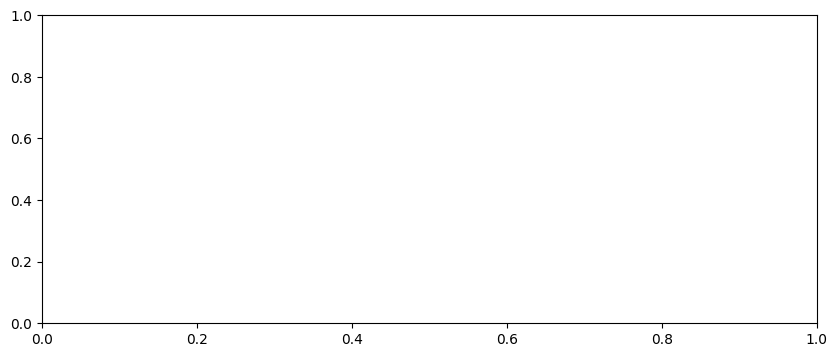

In [32]:
# Heatmap: Events (weekday x hour)
pivot_cnt = pd.pivot_table(df_evt, index="_weekday", columns="_hour", values="_downtime_total_min", aggfunc="count", fill_value=0)

# Ordnung Wochentage
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot_cnt = pivot_cnt.reindex([d for d in weekday_order if d in pivot_cnt.index])

make_heatmap(pivot_cnt, "Events nach Wochentag × Stunde", "Stunde", "Wochentag")

# Heatmap: Downtime Summe
pivot_sum = pd.pivot_table(df_evt, index="_weekday", columns="_hour", values="_downtime_total_min", aggfunc="sum", fill_value=0)
pivot_sum = pivot_sum.reindex(pivot_cnt.index)
make_heatmap(pivot_sum, "Downtime-Summe (min) nach Wochentag × Stunde", "Stunde", "Wochentag")

# Daily trend + rolling mean
daily = (
    df_evt.dropna(subset=["_ts_start"])
    .set_index("_ts_start")
    .resample("D")
    .agg(events=("_downtime_total_min","count"), downtime_sum=("_downtime_total_min","sum"), downtime_mean=("_downtime_total_min","mean"))
)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily.index, daily["events"])
ax.plot(daily.index, daily["events"].rolling(7, min_periods=3).mean())
ax.set_title("Events pro Tag (inkl. 7-Tage Rolling Mean)")
ax.set_xlabel("Datum")
ax.set_ylabel("Events")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily.index, daily["downtime_sum"])
ax.plot(daily.index, daily["downtime_sum"].rolling(7, min_periods=3).mean())
ax.set_title("Downtime-Summe pro Tag (min) (inkl. 7-Tage Rolling Mean)")
ax.set_xlabel("Datum")
ax.set_ylabel("Downtime (min)")
plt.tight_layout()
plt.show()

In [ ]:
### Burst-/Cluster-Erkennung: „Viele Stops in kurzer Zeit“ pro Station

In [33]:
# Für jede Station: Anzahl Events innerhalb der letzten 60 Minuten (rolling)
df_burst = df_evt.dropna(subset=["_ts_start"]).sort_values("_ts_start").copy()
df_burst = df_burst.set_index("_ts_start")

# Rolling count pro Station
burst_60 = (
    df_burst.groupby("_station")["_downtime_total_min"]
    .rolling("60min")
    .count()
    .rename("events_last_60min")
    .reset_index()
)

df_burst = df_burst.reset_index().merge(burst_60, on=["_station","_ts_start"], how="left")

# Top Bursts
top_bursts = df_burst.sort_values("events_last_60min", ascending=False)[["_ts_start","_station","_cause","_downtime_total_min","events_last_60min"]].head(30)
display(top_bursts)

# Verteilung: Wie oft kommen >=3 Events/60min vor?
print("Anteil Events mit >=3 Events in 60min Fenster:", (df_burst["events_last_60min"]>=3).mean())

,_ts_start,_station,_cause,_downtime_total_min,events_last_60min
1119,2023-02-02 02:00:00,R 03,Freitext,65.0,4.0
1122,2023-02-02 02:00:00,R 03,Greiferfehler Lattentasche,65.0,4.0
214,2023-01-12 10:00:00,R 06,Freitext,90.0,3.0
3177,2023-03-14 18:00:00,OP 100 R,Bauteil nicht gespannt,70.0,3.0
2357,2023-02-24 08:00:00,OP 100 R,Freitext,70.0,3.0
3003,2023-03-10 10:00:00,R 09,Freitext,65.0,3.0
212,2023-01-12 10:00:00,R 06,Freitext,90.0,3.0
3001,2023-03-10 10:00:00,R 09,Freitext,65.0,3.0
163,2023-01-11 10:00:00,R 06,Freitext,75.0,3.0
3175,2023-03-14 18:00:00,OP 100 R,Bauteil nicht gespannt,65.0,3.0


Anteil Events mit >=3 Events in 60min Fenster: 0.005303957568339453


In [ ]:
### Interaktionen: Station×Ursache×Schicht + „Lift“ (überproportional)

In [34]:
# Top Kombos nach Downtime-Summe / Events
combo2 = (
    df_evt.groupby(["_station","_cause"])["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", downtime_mean="mean")
    .sort_values(["downtime_sum","events"], ascending=False)
)
display(combo2.head(30))

combo3 = (
    df_evt.groupby(["_shift","_station","_cause"])["_downtime_total_min"]
    .agg(events="count", downtime_sum="sum", downtime_mean="mean")
    .sort_values(["downtime_sum","events"], ascending=False)
)
display(combo3.head(30))

# Lift: P(cause | shift) / P(cause)
base = df_evt["_cause"].value_counts(normalize=True)
by_shift = (
    df_evt.groupby("_shift")["_cause"]
    .value_counts(normalize=True)
    .rename("p_cause_given_shift")
    .reset_index()
)
by_shift["p_cause"] = by_shift["_cause"].map(base)
by_shift["lift"] = by_shift["p_cause_given_shift"] / by_shift["p_cause"]

# Top overrepresented Ursachen je Schicht (mindestens 30 Events zur Stabilität)
counts = df_evt.groupby(["_shift","_cause"]).size().rename("n").reset_index()
lift = by_shift.merge(counts, on=["_shift","_cause"], how="left")
lift = lift[lift["n"] >= 30].sort_values(["_shift","lift"], ascending=[True, False])

display(lift.groupby("_shift").head(10))

,,events,downtime_sum,downtime_mean
_station,_cause,,,
OP 100 R,Bauteil nicht gespannt,555,32640.0,58.810811
R 06,Zündfehler,296,18343.0,61.969595
R 09,Zündfehler,233,14386.0,61.742489
R 06,Freitext,175,11635.0,66.485714
R 07,Zündfehler,184,11632.0,63.217391
R 03,Freitext,155,9941.0,64.135484
R 02,Freitext,147,9728.0,66.176871
R 03,Greiferfehler Lattentasche,113,6949.0,61.495575
OP 100 R,Freitext,94,6938.0,73.808511


events  downtime_sum  downtime_mean
_shift _station _cause                                                         
n      OP 100 R Bauteil nicht gespannt         196       11407.0       58.19898
f      OP 100 R Bauteil nicht gespannt         186       11064.0      59.483871
s      OP 100 R Bauteil nicht gespannt         162        9561.0      59.018519
n      R 06     Zündfehler                     103        6308.0      61.242718
f      R 06     Zündfehler                      99        6176.0      62.383838
s      R 09     Zündfehler                      90        5487.0      60.966667
n      R 09     Zündfehler                      78        4883.0      62.602564
s      R 06     Zündfehler                      78        4844.0      62.102564
       R 07     Zündfehler                      64        4052.0        63.3125
n      R 06     Freitext                        62        3994.0      64.419355
s      R 02     Freitext                        59        3837.0      65.033898
       R 06     Freitext                        54        3807.0           70.5
f      R 09     Zündfehler                      61        3776.0      61.901639
       R 06     Freitext                        58        3769.0      64.982759
       R 07     Zündfehler                      59        3753.0      63.610169
n      R 07     Zündfehler                      57        3597.0      63.105263
       R 03     Freitext                        56        3594.0      64.178571
s      R 03     Freitext                        56        3578.0      63.892857
f      R 03     Greiferfehler Lattentasche      54        3305.0      61.203704
       R 02     Freitext                        46        3107.0      67.543478
       R 09     Freitext                        46        2934.0      63.782609
       OP 100 R Freitext                        37        2816.0      76.108108
n      R 03     Greiferfehler Lattentasche      42        2557.0      60.880952
s      R 08     Zündfehler                      41        2526.0      61.609756
n      R 02     Freitext                        38        2508.0           66.0
f      R 08     Zündfehler                      38        2358.0      62.052632
       R 03     Freitext                        38        2354.0      61.947368
n      R 09     Freitext                        33        2242.0      67.939394
       OP 100 R Freitext                        30        2119.0      70.633333
       OP 100 L Freitext                        26        2086.0      80.230769

,_shift,_cause,p_cause_given_shift,p_cause,lift,n
6,f,Greiferfehler Lattentasche,0.035382,0.024931,1.419201,57
7,f,Bauteil fallen gelassen,0.026071,0.020243,1.287896,42
9,f,Messfehler,0.021105,0.016620,1.269812,34
3,f,Gasdüse und Kontaktrohr getauscht,0.066418,0.052845,1.256861,107
8,f,Sensor Schaltet nicht,0.023588,0.020030,1.177635,38
4,f,Reinigung,0.055866,0.051140,1.092412,90
5,f,Wartungsplan,0.052142,0.052632,0.990689,84
0,f,Freitext,0.259466,0.273173,0.949824,418
2,f,Bauteil nicht gespannt,0.142148,0.151928,0.935623,229
1,f,Zündfehler,0.183116,0.196250,0.933077,295


In [ ]:
### Severity-Klassen (Dauerklassen) + Kombos

In [35]:
# Severity Bins
bins = [-np.inf, 5, 15, 30, 60, np.inf]
labels = ["<5", "5-15", "15-30", "30-60", ">60"]
df_sev = df_evt.copy()
df_sev["_severity"] = pd.cut(df_sev["_downtime_total_min"], bins=bins, labels=labels)

# Ursache × Severity (Counts)
pv = pd.pivot_table(df_sev, index="_cause", columns="_severity", values="_downtime_total_min", aggfunc="count", fill_value=0)
pv["total"] = pv.sum(axis=1)
pv = pv.sort_values("total", ascending=False)
display(pv.head(20))

# Station × Severity (Counts)
pv2 = pd.pivot_table(df_sev, index="_station", columns="_severity", values="_downtime_total_min", aggfunc="count", fill_value=0)
pv2["total"] = pv2.sum(axis=1)
pv2 = pv2.sort_values("total", ascending=False)
display(pv2.head(20))

# Schicht × Severity (Share)
pv3 = pd.pivot_table(df_sev, index="_shift", columns="_severity", values="_downtime_total_min", aggfunc="count", fill_value=0)
pv3_share = pv3.div(pv3.sum(axis=1), axis=0)
display(pv3_share)

_severity,15-30,30-60,>60,total
_cause,,,,
Freitext,0,110,1172,1282
Zündfehler,1,86,834,921
Bauteil nicht gespannt,18,280,415,713
Gasdüse und Kontaktrohr getauscht,0,54,194,248
Wartungsplan,0,2,245,247
Reinigung,0,8,232,240
Greiferfehler Lattentasche,2,22,93,117
Gasdüse getauscht,0,15,88,103
Bauteil fallen gelassen,0,14,81,95


_severity,15-30,30-60,>60,total
_station,,,,
OP 100 R,17,265,450,732
R 06,1,47,520,568
R 09,0,44,401,445
R 07,0,28,310,338
R 02,0,38,298,336
R 03,2,41,271,314
OP 100 L,2,38,156,196
R 08,0,21,164,185
R 04,0,7,118,125


_severity,15-30,30-60,>60
_shift,,,
f,0.0,0.121862,0.878138
n,0.013935,0.163902,0.822163
s,0.000683,0.150171,0.849147
t,0.0,0.285714,0.714286


In [ ]:
### Ausreißer-Analyse (Top-Langstopps + Vergleich „Outlier vs Normal“)

In [36]:
# Schwellen: P95 / P99
p95 = df_evt["_downtime_total_min"].quantile(0.95)
p99 = df_evt["_downtime_total_min"].quantile(0.99)
print("P95:", p95, "P99:", p99)

df_out = df_evt.copy()
df_out["_is_outlier_p95"] = df_out["_downtime_total_min"] >= p95

# Top 50 längste
top_long = df_out.sort_values("_downtime_total_min", ascending=False).head(50)[
    ["_ts_start","_shift","_station","_cause","_ma","_qty","_downtime_total_min"]
]
display(top_long)

# Vergleich Outlier vs Normal
cmp = (
    df_out.groupby("_is_outlier_p95")
    .agg(
        n=("_downtime_total_min","size"),
        downtime_mean=("_downtime_total_min","mean"),
        ma_mean=("_ma","mean"),
        qty_mean=("_qty","mean"),
    )
)
display(cmp)

# Welche Ursachen/Stationen dominieren bei Outliers?
out_cause = df_out[df_out["_is_outlier_p95"]]["_cause"].value_counts().head(20)
out_station = df_out[df_out["_is_outlier_p95"]]["_station"].value_counts().head(20)
display(out_cause.to_frame("outlier_events"))
display(out_station.to_frame("outlier_events"))

P95: 83.00000000000011 P99: 119.99999999999987


,_ts_start,_shift,_station,_cause,_ma,_qty,_downtime_total_min
8293,NaT,n,NaN,Reinigung,4.0,NaN,120.0
8305,NaT,n,NaN,Freitext,1.0,NaN,120.0
981,2023-01-18 22:00:00,n,OP 100 L,Freitext,6.0,NaN,120.0
189,2023-01-09 22:00:00,n,NaN,Warten auf Material,3.0,NaN,120.0
377,2023-01-11 16:00:00,s,R 06,Freitext,4.0,1.0,120.0
5181,2023-03-14 19:00:00,s,R 04,Zündfehler,4.0,NaN,120.0
1181,2023-01-20 19:00:00,s,R 08,Freitext,NaN,NaN,120.0
6873,2023-04-05 19:00:00,s,NaN,NaN,5.0,NaN,120.0
6861,2023-04-05 16:00:00,s,NaN,NaN,5.0,NaN,120.0
389,2023-01-11 19:00:00,s,R 06,Freitext,1.0,NaN,120.0


,n,downtime_mean,ma_mean,qty_mean
_is_outlier_p95,,,,
False,4532,64.376655,4.074487,1.184543
True,248,96.834677,4.016667,1.406250


,outlier_events
_cause,
Freitext,134
Wartungsplan,42
Reinigung,16
Störung,9
Schweißdraht tauschen,6
Zündfehler,5
Warten auf Material,5
Räumen,4
Bauteil fallen gelassen,4


,outlier_events
_station,
OP 100 L,21
OP 100 R,19
R 06,13
OP 60,13
R 08,13
R 07,10
R 02,9
R 03,7
R 09,7


In [ ]:
### Cramér’s V (Zusammenhangsstärke für kategoriale Kombinationen)

In [37]:
def cramers_v(x: pd.Series, y: pd.Series):
    # basiert auf Chi^2
    tab = pd.crosstab(x, y)
    if tab.shape[0] < 2 or tab.shape[1] < 2:
        return np.nan
    chi2 = ((tab - tab.mean(axis=0))**2 / (tab.mean(axis=0) + 1e-9)).to_numpy().sum()  # einfache Approx
    n = tab.to_numpy().sum()
    r, k = tab.shape
    phi2 = chi2 / (n + 1e-9)
    return np.sqrt(phi2 / (min(k-1, r-1) + 1e-9))

# Beispiele
print("Cramér's V: Schicht vs Ursache:", cramers_v(df_evt["_shift"], df_evt["_cause"]))

# Zeitblock (z.B. 0-6 / 6-14 / 14-22 / 22-24)
df_tmp = df_evt.dropna(subset=["_hour"]).copy()
df_tmp["_timeblock"] = pd.cut(df_tmp["_hour"], bins=[-1,5,13,21,23], labels=["0-5","6-13","14-21","22-23"])
print("Cramér's V: Zeitblock vs Ursache:", cramers_v(df_tmp["_timeblock"], df_tmp["_cause"]))

# MA-Bins vs Ursache (nur wenn MA vorhanden)
if df_evt["_ma"].notna().any():
    df_tmp2 = df_evt.copy()
    df_tmp2["_ma_bin"] = pd.cut(df_tmp2["_ma"], bins=[-np.inf, 1, 2, 3, 5, np.inf], labels=["<=1","2","3","4-5",">5"])
    print("Cramér's V: MA_bin vs Ursache:", cramers_v(df_tmp2["_ma_bin"], df_tmp2["_cause"]))

Cramér's V: Schicht vs Ursache: 0.3611329273015178
Cramér's V: Zeitblock vs Ursache: 0.28164720977179275
Cramér's V: MA_bin vs Ursache: 0.8010058046513916


In [ ]:
### Freitext nutzbar machen: Normalisieren + Clustering (TF-IDF + KMeans)

In [38]:
# Freitext extrahieren: bevorzugt Kommentarspalte, sonst Ursache selbst
text_src = None
if COL_COMMENT:
    text_src = df_evt[COL_COMMENT].astype(str)
else:
    text_src = df_evt["_cause"].astype(str)

# Filter: nur wirklich "Freitext"-artige Zeilen
mask_ft = df_evt["_cause"].str.contains("freitext", case=False, na=False) if COL_CAUSE else pd.Series([False]*len(df_evt))
df_ft = df_evt.loc[mask_ft].copy()
if df_ft.empty:
    print("Keine Zeilen mit Ursache ~ Freitext gefunden. Nutze alternativ Kommentarspalte direkt.")
    df_ft = df_evt.dropna(subset=[COL_COMMENT]).copy() if COL_COMMENT else df_evt.copy()

df_ft["_text_raw"] = (df_ft[COL_COMMENT].astype(str) if COL_COMMENT else df_ft["_cause"].astype(str)).fillna("")
df_ft["_text"] = (
    df_ft["_text_raw"].str.lower()
    .str.replace(r"[^a-zäöüß0-9\s\-]", " ", regex=True)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Cluster
try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans

    vec = TfidfVectorizer(min_df=3, max_df=0.8, ngram_range=(1,2))
    X = vec.fit_transform(df_ft["_text"])

    k = 10  # ggf. anpassen
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    df_ft["_topic"] = km.fit_predict(X)

    # Top Begriffe je Cluster
    terms = np.array(vec.get_feature_names_out())
    centers = km.cluster_centers_
    for i in range(k):
        top_idx = np.argsort(centers[i])[::-1][:12]
        print(f"\nCluster {i} top terms:", ", ".join(terms[top_idx]))

    # Cluster KPIs
    topic_stats = (
        df_ft.groupby("_topic")["_downtime_total_min"]
        .agg(n="count", downtime_sum="sum", downtime_mean="mean")
        .sort_values("downtime_sum", ascending=False)
    )
    display(topic_stats)

except ImportError as e:
    print("sklearn fehlt. Installiere scikit-learn oder entferne den Block:", e)


Cluster 0 top terms: in, nicht, anlage, rob, rob tech, tech, informiert, tech informiert, getauscht, op, hat, robtech

Cluster 1 top terms: referenzieren, neu referenzieren, neu, von, 2814, auf, zündfehler, zylinder öffnet, zylinder, zwecks abluftanlagentransport, zwecks, zurück zündfehler

Cluster 2 top terms: ausrichtstation, zündfehler als, zündfehler, zylinder öffnet, zylinder, zwecks abluftanlagentransport, zwecks, zurück zündfehler, zurück, zur, zum hinteren, zum

Cluster 3 top terms: schweißer, ab, 30, nur, nur schweißer, türanlage, 15, 07, 14, zum, reinigung, kein

Cluster 4 top terms: suchfahrt, in, zündfehler als, zündfehler, zylinder öffnet, zylinder, zwecks abluftanlagentransport, zwecks, zurück zündfehler, zurück, zur, zum hinteren

Cluster 5 top terms: suchfahrtfehler, scharnier, zündfehler suchfehler, zündfehler als, zündfehler, zylinder öffnet, zylinder, zwecks abluftanlagentransport, zwecks, zurück zündfehler, zurück, zur

Cluster 6 top terms: falsch abgelegt, abgeleg

,n,downtime_sum,downtime_mean
_topic,,,
0,811,57790.0,71.257707
2,129,8046.0,62.372093
4,78,4937.0,63.294872
5,69,4235.0,61.376812
8,38,3368.0,88.631579
6,50,3246.0,64.92
7,36,2512.0,69.777778
1,36,2322.0,64.5
9,30,1941.0,64.7


In [39]:
if df_evt["_qty"].notna().any():
    df_rate = df_evt.dropna(subset=["_ts_start"]).copy()
    df_rate["_day"] = df_rate["_ts_start"].dt.date

    daily_station = (
        df_rate.groupby(["_day","_station"])
        .agg(events=("_downtime_total_min","count"),
             downtime_sum=("_downtime_total_min","sum"),
             qty_sum=("_qty","sum"))
        .reset_index()
    )

    daily_station["events_per_1000"] = daily_station["events"] / (daily_station["qty_sum"] / 1000.0)
    daily_station["downtime_per_unit"] = daily_station["downtime_sum"] / daily_station["qty_sum"]

    display(daily_station.sort_values("events_per_1000", ascending=False).head(30))
else:
    print("Keine/zu wenig Menge-Spalte erkannt (Menge Gesamt). Überspringe normalisierte KPIs.")

,_day,_station,events,downtime_sum,qty_sum,events_per_1000,downtime_per_unit
1322,2023-05-16,R 09,1,63.0,0.0,inf,inf
1321,2023-05-16,R 08,1,63.0,0.0,inf,inf
1319,2023-05-16,"R 07, R 08",1,66.0,0.0,inf,inf
2,2023-01-05,R 03,4,350.0,0.0,inf,inf
3,2023-01-05,R 06,1,90.0,0.0,inf,inf
1318,2023-05-16,R 07,1,65.0,0.0,inf,inf
1299,2023-05-15,OP 100 L,4,229.0,0.0,inf,inf
1298,2023-05-14,R 09,1,65.0,0.0,inf,inf
1297,2023-05-14,R 06,1,65.0,0.0,inf,inf
1296,2023-05-14,OP 25 S,1,65.0,0.0,inf,inf


In [40]:
def build_timeseries_for_station(df_events: pd.DataFrame, station: str, freq="15min"):
    d = df_events[(df_events["_station"] == station) & df_events["_ts_start"].notna()].copy()
    if d.empty:
        return None

    d = d.sort_values("_ts_start").set_index("_ts_start")

    # Raster
    idx = pd.date_range(d.index.min().floor(freq), d.index.max().ceil(freq), freq=freq)
    grid = pd.DataFrame(index=idx)

    # Event-Kennzahlen pro Bin
    per_bin = d.resample(freq).agg(
        events=("_downtime_total_min","count"),
        downtime_sum=("_downtime_total_min","sum"),
        downtime_mean=("_downtime_total_min","mean"),
        ma_mean=("_ma","mean"),
    )

    # Ursache: Top Ursachen one-hot (pro Bin zählen)
    top_causes = d["_cause"].value_counts().head(10).index.tolist()
    cause_counts = (
        d[d["_cause"].isin(top_causes)]
        .groupby("_cause")["_downtime_total_min"]
        .resample(freq)
        .count()
        .unstack(0)
        .reindex(idx)
        .fillna(0)
        .add_prefix("cause_cnt__")
    )

    grid = grid.join(per_bin).join(cause_counts)
    grid = grid.fillna(0)

    # Zeitfeatures
    grid["hour"] = grid.index.hour
    grid["weekday"] = grid.index.dayofweek
    return grid

def add_rolling_features(ts: pd.DataFrame, windows=(4, 8, 16)):  # bei 15min -> 1h,2h,4h
    out = ts.copy()
    for w in windows:
        out[f"roll_events_{w}"] = out["events"].rolling(w, min_periods=1).sum()
        out[f"roll_downtime_{w}"] = out["downtime_sum"].rolling(w, min_periods=1).sum()
    out["time_since_last_event_bins"] = (out["events"]>0).astype(int).replace(0, np.nan).ffill()
    return out.fillna(0)

def make_horizon_target(ts: pd.DataFrame, horizon_bins=4):
    # Target: kommt im nächsten horizon irgendein Event?
    future_events = ts["events"].rolling(horizon_bins, min_periods=1).sum().shift(-horizon_bins)
    y = (future_events > 0).astype(int).fillna(0)
    return y

# Beispiel: Dataset für Top 3 Stationen
top_stations = df_evt["_station"].value_counts().head(3).index.tolist()
series_dict = {}

for st in top_stations:
    ts = build_timeseries_for_station(df_evt, st, freq="15min")
    if ts is None:
        continue
    ts = add_rolling_features(ts)
    ts["y_next_1h"] = make_horizon_target(ts, horizon_bins=4)  # 4*15min = 1h
    series_dict[st] = ts
    print(st, ts.shape)

# Beispiel ansehen
if series_dict:
    st0 = list(series_dict.keys())[0]
    display(series_dict[st0].head(30))

OP 100 R (11649, 24)
R 06 (12585, 24)
R 09 (12565, 24)


,events,downtime_sum,downtime_mean,ma_mean,cause_cnt__Bauteil nicht gelöst,cause_cnt__Bauteil nicht gespannt,cause_cnt__Bauteil räumen,cause_cnt__Freitext,cause_cnt__Räumen,cause_cnt__Sensor Schaltet nicht,cause_cnt__Spanner schließt nicht,cause_cnt__Störung,cause_cnt__Verstärkungsprofil,cause_cnt__bauteil nicht gespannt,hour,weekday,roll_events_4,roll_downtime_4,roll_events_8,roll_downtime_8,roll_events_16,roll_downtime_16,time_since_last_event_bins,y_next_1h
2023-01-10 08:00:00,1,68.0,68.0,5.0,0,0,0,1,0,0,0,0,0,0,8,1,1.0,68.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 08:15:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,8,1,1.0,68.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 08:30:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,8,1,1.0,68.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 08:45:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,8,1,1.0,68.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 09:00:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9,1,0.0,0.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 09:15:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9,1,0.0,0.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 09:30:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9,1,0.0,0.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 09:45:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,9,1,0.0,0.0,1.0,68.0,1.0,68.0,1.0,0
2023-01-10 10:00:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,10,1,0.0,0.0,0.0,0.0,1.0,68.0,1.0,0
2023-01-10 10:15:00,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,10,1,0.0,0.0,0.0,0.0,1.0,68.0,1.0,0
